# Policy Briefing Title that Matches PDF Title

## CASA0013: Foundations of Spatial Data Science

### Student Ids: ucfther, ucftYYYY, etc.

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import re
import os

from matplotlib.colors import ListedColormap

# All of these are potentially useful, though
# not all have been used in this practical --
# I'd suggest exploring the use of different 
# Scalers/Transformers as well as clustering 
# algorithms...
import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import silhouette_samples, silhouette_score

import random
random.seed(42)    # For reproducibility
np.random.seed(42) # For reproducibility

# Make numeric display a bit neater
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

Font set up

In [2]:
tfont = {'fontname':'Liberation Sans Narrow', 'weight':'bold'}
bfont = {'fontname':'Liberation Sans Narrow', 'weight':'normal', 'horizontalalignment':'left'}
afont = {'fontname':'Liberation Sans Narrow', 'weight':'light'}

# Read in data

### caching set up

In [3]:
import os
from requests import get
from urllib.parse import urlparse

def cache_data(src:str, dest:str) -> str:
    """Downloads and caches a remote file locally.
    
    The function sits between the 'read' step of a pandas or geopandas
    data frame and downloading the file from a remote location. The idea
    is that it will save it locally so that you don't need to remember to
    do so yourself. Subsequent re-reads of the file will return instantly
    rather than downloading the entire file for a second or n-th itme.
    
    Parameters
    ----------
    src : str
        The remote *source* for the file, any valid URL should work.
    dest : str
        The *destination* location to save the downloaded file.
        
    Returns
    -------
    str
        A string representing the local location of the file.
    """
    
    url = urlparse(src) # We assume that this is some kind of valid URL 
    fn  = os.path.split(url.path)[-1] # Extract the filename
    dfn = os.path.join(dest,fn) # Destination filename
    
    # Check if dest+filename does *not* exist -- 
    # that would mean we have to download it!
    if not os.path.isfile(dfn) or os.path.getsize(dfn) < 1:
        
        print(f"{dfn} not found, downloading!")

        # Convert the path back into a list (without)
        # the filename -- we need to check that directories
        # exist first.
        path = os.path.split(dest)
        
        # Create any missing directories in dest(ination) path
        # -- os.path.join is the reverse of split (as you saw above)
        # but it doesn't work with lists... so I had to google how
        # to use the 'splat' operator! os.makedirs creates missing
        # directories in a path automatically.
        if len(path) >= 1 and path[0] != '':
            os.makedirs(os.path.join(*path), exist_ok=True)
            
        # Download and write the file
        with open(dfn, "wb") as file:
            response = get(src)
            file.write(response.content)
            
        print('Done downloading...')

    else:
        print(f"Found {dfn} locally!")

    return dfn

## LSOA data

In [4]:
src_url   = 'https://data.london.gov.uk/download/lsoa-atlas/0193f884-2ccd-49c2-968e-28aa3b1c480d/lsoa-data.csv'
dest_path = os.path.join('data','lsoa')

lsoa_atlas = pd.read_csv(cache_data(src_url, dest_path), encoding= 'unicode_escape')        

Found data/lsoa/lsoa-data.csv locally!


/tmp/ipykernel_19025/548347365.py:4: DtypeWarning: Columns (174,175,176,178,189,253,254) have mixed types. Specify dtype option on import or set low_memory=False.
  lsoa_atlas = pd.read_csv(cache_data(src_url, dest_path), encoding= 'unicode_escape')


In [5]:
lsoa_atlas.head(1)

Lower Super Output Area        Names  \
0               E01000907  Camden 001A   

   Mid-year Population Estimates;All Ages;2001  \
0                                     1,519.00   

   Mid-year Population Estimates;All Ages;2002  \
0                                     1,538.00   

   Mid-year Population Estimates;All Ages;2003  \
0                                     1,528.00   

   Mid-year Population Estimates;All Ages;2004  \
0                                     1,547.00   

   Mid-year Population Estimates;All Ages;2005  \
0                                     1,593.00   

   Mid-year Population Estimates;All Ages;2006  \
0                                     1,492.00   

   Mid-year Population Estimates;All Ages;2007  \
0                                     1,455.00   

   Mid-year Population Estimates;All Ages;2008  ...  \
0                                     1,457.00  ...   

   Road Casualties;2012;Slight  Road Casualties;2012;2012 Total  \
0                         0.00                             2.00   

   Road Casualties;2013;Fatal  Road Casualties;2013;Serious  \
0                        0.00                          0.00   

   Road Casualties;2013;Slight  Road Casualties;2013;2013 Total  \
0                         0.00                             0.00   

   Road Casualties;2014;Fatal  Road Casualties;2014;Serious  \
0                        0.00                          0.00   

   Road Casualties;2014;Slight  Road Casualties;2014;2014 Total  
0                         0.00                             0.00  

[1 rows x 277 columns]

In [6]:
print(f"Shape of the LSOA Atlas data frame is: {lsoa_atlas.shape[0]:,} x {lsoa_atlas.shape[1]:,}")

Shape of the LSOA Atlas data frame is: 4,837 x 277


In [7]:
tidy = lsoa_atlas.loc[:,lsoa_atlas.columns.str.startswith(('Lower Super Output Area', 'Names','2011 Census Population','Population Density', 
                                                           'Households', 'Household Composition','Ethnic Group', 'Country of Birth',
                                                          'House Prices','Health', 'Public Transport Accessibility Levels', 'Household Income'))]

print(f"Shape of the LSOA Atlas data frame is now: {tidy.shape[0]} x {tidy.shape[1]}")

Shape of the LSOA Atlas data frame is now: 4837 x 72


In [8]:
tidy.head()

Lower Super Output Area        Names  \
0               E01000907  Camden 001A   
1               E01000908  Camden 001B   
2               E01000909  Camden 001C   
3               E01000912  Camden 001D   
4               E01000913  Camden 001E   

   2011 Census Population;Age Structure;All Ages  \
0                                       1,430.00   
1                                       1,581.00   
2                                       1,614.00   
3                                       1,589.00   
4                                       1,710.00   

   Population Density;Area (Hectares);  \
0                                10.70   
1                                17.50   
2                                22.90   
3                                89.60   
4                               161.70   

   Population Density;Persons per hectare;2012  \
0                                       136.00   
1                                        92.00   
2                                        70.00   
3                                        18.00   
4                                        11.00   

   Population Density;Persons per hectare;2013  \
0                                       137.00   
1                                        94.00   
2                                        72.00   
3                                        18.00   
4                                        11.00   

   Households;All households;2011  \
0                          627.00   
1                          827.00   
2                          661.00   
3                          700.00   
4                          722.00   

   Household Composition;Couple household with dependent children;2011  \
0                                              77.00                     
1                                              96.00                     
2                                             118.00                     
3                                              90.00                     
4                                             139.00                     

   Household Composition;Couple household without dependent children;2011  \
0                                             126.00                        
1                                             143.00                        
2                                             194.00                        
3                                             116.00                        
4                                             250.00                        

   Household Composition;Lone parent household;2011  ...  \
0                                            132.00  ...   
1                                            109.00  ...   
2                                             48.00  ...   
3                                            110.00  ...   
4                                             27.00  ...   

   Public Transport Accessibility Levels (2014);Number of people in each PTAL level:;4  \
0                                             439.00                                     
1                                               0.00                                     
2                                               0.00                                     
3                                             312.00                                     
4                                               8.00                                     

   Public Transport Accessibility Levels (2014);Number of people in each PTAL level:;5  \
0                                             217.00                                     
1                                               0.00                                     
2                                               0.00                                     
3                                             348.00                                     
4                                               0.00                                     

   Publ

In [9]:
tidy.drop(tidy[tidy.Names.isnull()].index.array, axis=0, inplace=True)
print(f"Shape of the LSOA Atlas data frame is now: {tidy.shape[0]} x {tidy.shape[1]}")

Shape of the LSOA Atlas data frame is now: 4835 x 72


/tmp/ipykernel_19025/3162247456.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tidy.drop(tidy[tidy.Names.isnull()].index.array, axis=0, inplace=True)


In [10]:
tidy['Borough'] = tidy['Names'].str.replace(' \d+[A-Z]$','',regex=True)
tidy.Borough.unique()

/tmp/ipykernel_19025/2748768919.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tidy['Borough'] = tidy['Names'].str.replace(' \d+[A-Z]$','',regex=True)


array(['Camden', 'City of London', 'Hackney', 'Hammersmith and Fulham',
       'Haringey', 'Islington', 'Kensington and Chelsea', 'Lambeth',
       'Lewisham', 'Newham', 'Southwark', 'Tower Hamlets', 'Wandsworth',
       'Westminster', 'Barking and Dagenham', 'Barnet', 'Bexley', 'Brent',
       'Bromley', 'Croydon', 'Ealing', 'Enfield', 'Greenwich', 'Harrow',
       'Havering', 'Hillingdon', 'Hounslow', 'Kingston upon Thames',
       'Merton', 'Redbridge', 'Richmond upon Thames', 'Sutton',
       'Waltham Forest'], dtype=object)

In [11]:
mapping = {}
for b in ['Enfield','Waltham Forest','Redbridge','Barking and Dagenham','Havering','Greenwich','Bexley']:
    mapping[b]='Outer East and North East'
for b in ['Haringey','Islington','Hackney','Tower Hamlets','Newham','Lambeth','Southwark','Lewisham']:
    mapping[b]='Inner East'
for b in ['Bromley','Croydon','Sutton','Merton','Kingston upon Thames']:
    mapping[b]='Outer South'
for b in ['Wandsworth','Kensington and Chelsea','Hammersmith and Fulham','Westminster','Camden','City of London']:
    mapping[b]='Inner West'
for b in ['Richmond upon Thames','Hounslow','Ealing','Hillingdon','Brent','Harrow','Barnet']:
    mapping[b]='Outer West and North West'

tidy['Subregion'] = tidy.Borough.apply(lambda x: mapping[x])

/tmp/ipykernel_19025/2016648035.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tidy['Subregion'] = tidy.Borough.apply(lambda x: mapping[x])


In [12]:
tidy.loc[:,'House Prices;Median Price (£);2012']
# House prices columns contain mixed styles.. so conversion is needed

0          355000
1          335000
2         1475000
3          373000
4          737500
          ...    
4830   225,000.00
4831   222,500.00
4832   246,995.00
4833   207,500.00
4834   222,250.00
Name: House Prices;Median Price (£);2012, Length: 4835, dtype: object

In [13]:
str_cols = ['House Prices;Median Price (£);2009', 'House Prices;Median Price (£);2010',
 'House Prices;Median Price (£);2011', 'House Prices;Median Price (£);2012',
 'House Prices;Median Price (£);2013', 'House Prices;Median Price (£);2014']
tidy[str_cols] = tidy[str_cols].astype(str).replace('\.0$','',regex=True)

/tmp/ipykernel_19025/2353305197.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tidy[str_cols] = tidy[str_cols].astype(str).replace('\.0$','',regex=True)


In [14]:
tidy.loc[:,'House Prices;Median Price (£);2012'] # check if coversion worked -- good


0        355000
1        335000
2       1475000
3        373000
4        737500
         ...   
4830     225000
4831     222500
4832     246995
4833     207500
4834     222250
Name: House Prices;Median Price (£);2012, Length: 4835, dtype: object

In [15]:
#tidy['House Prices;Median Price (£);2012'] = pd.to_numeric(tidy['House Prices;Median Price (£);2012'], downcast="float")
# this gives ValueError: Unable to parse string "." at position 115
# so check row 115

In [16]:
print(tidy.loc[115,'House Prices;Median Price (£);2012']) # check row 115
tidy.loc[115]

.


Lower Super Output Area                                                    E01000940
Names                                                                    Camden 024D
2011 Census Population;Age Structure;All Ages                               1,130.00
Population Density;Area (Hectares);                                             4.90
Population Density;Persons per hectare;2012                                   220.00
                                                                            ...     
Public Transport Accessibility Levels (2014);% 4-6 (good access)              100.00
Household Income, 2011/12;Mean Annual Household Income estimate (£)        37,179.00
Household Income, 2011/12;Median Annual Household Income estimate (£)      28,095.00
Borough                                                                       Camden
Subregion                                                                 Inner West
Name: 115, Length: 74, dtype: object

In [17]:
tidy.loc[tidy.Names == 'Camden 024D'] # from the output, it seems like there is no duplicated rows for Camden 024D, so the '.' in house price should be kept and set as 0, rather than deleting the entire row to avoid missing one LSOA.

Lower Super Output Area        Names  \
115               E01000940  Camden 024D   

     2011 Census Population;Age Structure;All Ages  \
115                                       1,130.00   

     Population Density;Area (Hectares);  \
115                                 4.90   

     Population Density;Persons per hectare;2012  \
115                                       220.00   

     Population Density;Persons per hectare;2013  \
115                                       254.00   

     Households;All households;2011  \
115                          534.00   

     Household Composition;Couple household with dependent children;2011  \
115                                              64.00                     

     Household Composition;Couple household without dependent children;2011  \
115                                              91.00                        

     Household Composition;Lone parent household;2011  ...  \
115                                             52.00  ...   

     Public Transport Accessibility Levels (2014);Number of people in each PTAL level:;6a  \
115                                               0.00                                      

     Public Transport Accessibility Levels (2014);Number of people in each PTAL level:;6b  \
115                                           1,130.00                                      

     Public Transport Accessibility Levels (2014);Average Score;  \
115                                               8.00             

     Public Transport Accessibility Levels (2014);% 0-1 (poor access)  \
115                                               0.00                  

     Public Transport Accessibility Levels (2014);% 2-3 (average access)  \
115                                               0.00                     

     Public Transport Accessibility Levels (2014);% 4-6 (good access)  \
115                                             100.00                  

     Household Income, 2011/12;Mean Annual Household Income estimate (£)  \
115                                          37,179.00                     

     Household Income, 2011/12;Median Annual Household Income estimate (£)  \
115                                          28,095.00                       

     Borough   Subregion  
115   Camden  Inner West  

[1 rows x 74 columns]

In [18]:
tidy[str_cols] = tidy[str_cols].replace('\.','0',regex=True)

/tmp/ipykernel_19025/2738957865.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tidy[str_cols] = tidy[str_cols].replace('\.','0',regex=True)


In [19]:
tidy['House Prices;Median Price (£);2009'] = pd.to_numeric(tidy['House Prices;Median Price (£);2009'], downcast="float")
tidy['House Prices;Median Price (£);2010'] = pd.to_numeric(tidy['House Prices;Median Price (£);2010'], downcast="float")
tidy['House Prices;Median Price (£);2011'] = pd.to_numeric(tidy['House Prices;Median Price (£);2011'], downcast="float")
tidy['House Prices;Median Price (£);2012'] = pd.to_numeric(tidy['House Prices;Median Price (£);2012'], downcast="float")
tidy['House Prices;Median Price (£);2013'] = pd.to_numeric(tidy['House Prices;Median Price (£);2013'], downcast="float")
tidy['House Prices;Median Price (£);2014'] = pd.to_numeric(tidy['House Prices;Median Price (£);2014'], downcast="float")


/tmp/ipykernel_19025/42810702.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tidy['House Prices;Median Price (£);2009'] = pd.to_numeric(tidy['House Prices;Median Price (£);2009'], downcast="float")
/tmp/ipykernel_19025/42810702.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tidy['House Prices;Median Price (£);2010'] = pd.to_numeric(tidy['House Prices;Median Price (£);2010'], downcast="float")
/tmp/ipykernel_19025/42810702.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

In [20]:
tidy.loc[:,'House Prices;Median Price (£);2012'] # check if coversion worked -- good


0        355,000.00
1        335,000.00
2      1,475,000.00
3        373,000.00
4        737,500.00
           ...     
4830     225,000.00
4831     222,500.00
4832     246,995.00
4833     207,500.00
4834     222,250.00
Name: House Prices;Median Price (£);2012, Length: 4835, dtype: float32

In [21]:
tidy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 74 columns):
 #   Column                                                                                Non-Null Count  Dtype  
---  ------                                                                                --------------  -----  
 0   Lower Super Output Area                                                               4835 non-null   object 
 1   Names                                                                                 4835 non-null   object 
 2   2011 Census Population;Age Structure;All Ages                                         4835 non-null   float64
 3   Population Density;Area (Hectares);                                                   4835 non-null   float64
 4   Population Density;Persons per hectare;2012                                           4835 non-null   float64
 5   Population Density;Persons per hectare;2013                                        

In [22]:
# save the atlas to geofeather
tidy.to_feather(os.path.join('data','clean','LSOA_Atlas.feather'))
print("Done.")

Done.


merge lsoa data and geography

In [23]:
lsoas = gpd.read_file(
    cache_data('https://borders.ukdataservice.ac.uk/ukborders/easy_download/prebuilt/shape/infuse_lsoa_lyr_2011.zip', 
               os.path.join('data','geo','London_LSOAs.shp.zip')), driver='ESRI Shapefile')

Found data/geo/London_LSOAs.shp.zip/infuse_lsoa_lyr_2011.zip locally!


In [24]:
lsoas.columns.tolist()[:5]

['geo_code', 'geo_label', 'geo_labelw', 'label', 'name']

In [25]:
tidy.columns.tolist()[:5]

['Lower Super Output Area',
 'Names',
 '2011 Census Population;Age Structure;All Ages',
 'Population Density;Area (Hectares);',
 'Population Density;Persons per hectare;2012']

In [26]:
gdf = pd.merge(lsoas, tidy, left_on='geo_code', right_on='Lower Super Output Area', how='inner')
gdf = gdf.drop(columns=['geo_label', 'geo_labelw', 'label', 'name', 'Lower Super Output Area'])

print(f"Final LSOA Atlas data frame has shape {gdf.shape[0]:,} x {gdf.shape[1]}")

Final LSOA Atlas data frame has shape 4,835 x 75


plot

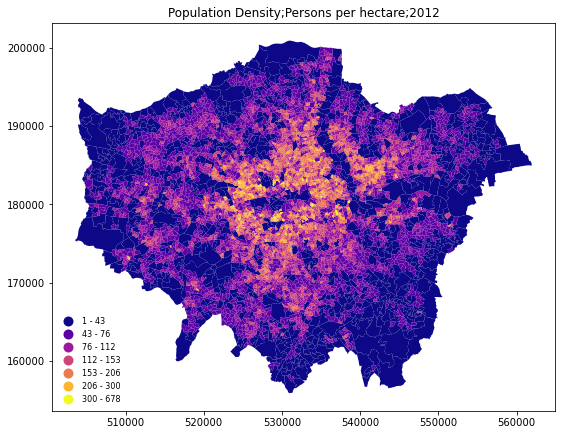

In [27]:
col = 'Population Density;Persons per hectare;2012'
fig = gdf.plot(column=col, cmap='plasma', 
         scheme='FisherJenks', k=7, edgecolor='None', 
         legend=True, legend_kwds={'frameon':False, 'fontsize':8},
         figsize=(9,8));
plt.title(col);

# Now to modify the legend: googling "geopandas format legend"
# brings me to: https://stackoverflow.com/a/56591102/4041902
leg = fig.get_legend()
leg._loc = 3

for lbl in leg.get_texts():
    label_text = lbl.get_text()
    [low, hi] = label_text.split(', ')
    new_text = f'{float(low):,.0f} - {float(hi):,.0f}'
    lbl.set_text(new_text)

plt.show();

In [28]:
gdf.to_feather(os.path.join('data','geo','LSOA_Atlas.geofeather'))
print("Done.")

Done.


## Boundary data

In [29]:
spath = 'https://github.com/jreades/fsds/blob/master/data/src/' # source path
ddir  = os.path.join('data','geo') # destination directory
water = gpd.read_file(cache_data(spath+'Water.gpkg?raw=true', ddir))
boros = gpd.read_file(cache_data(spath+'Boroughs.gpkg?raw=true', ddir))
green = gpd.read_file(cache_data(spath+'Greenspace.gpkg?raw=true', ddir))

lsoas = gpd.read_feather(os.path.join('data','geo','LSOA_Atlas.geofeather'))

print("Done.")

Found data/geo/Water.gpkg locally!
Found data/geo/Boroughs.gpkg locally!
Found data/geo/Greenspace.gpkg locally!
Done.


In [30]:
lsoas.crs

<Derived Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.0, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

<AxesSubplot:>

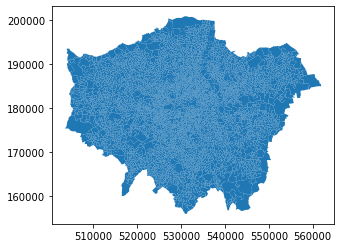

In [31]:
lsoas.plot() #to check

## Airbnb data 2016

In [32]:
# Set download URL
host   = 'https://orca.casa.ucl.ac.uk'
path16 = '~jreades/data/London-2016-02-02-listings.csv.gz'
url16  = f'{host}/{path16}'

airbnb_2016 = pd.read_csv(url16, compression='gzip', low_memory=False)
print(f"Data frame is {airbnb_2016.shape[0]:,} x {airbnb_2016.shape[1]}")


Data frame is 33,715 x 92


In [33]:
# save raw listing data locally
path = os.path.join('data','raw') 
fn16 = url16.split('/')[-1]         
print(f"Writing to: {fn16}")

if not os.path.exists(path):
    print(f"Creating {path} under {os.getcwd()}")
    os.makedirs(path)
    
airbnb_2016.to_csv(os.path.join(path,fn16), index=False)
print("Done.")

Writing to: London-2016-02-02-listings.csv.gz
Done.


In [34]:
print(airbnb_2016.columns.to_list())

['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude', 'is_location_exact', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet', 'price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'gues

### Data cleaning

In [35]:
cols_2016 = ['id', 'name', 'host_id', 'host_name', 'neighbourhood_cleansed', 'latitude', 'longitude', 
 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 
 'calculated_host_listings_count', 'availability_365']

In [36]:
airbnb_2016 = pd.read_csv(os.path.join(path,fn16), 
                low_memory=False, usecols=cols_2016)
print(f"Data frame is {airbnb_2016.shape[0]:,} x {airbnb_2016.shape[1]}")

Data frame is 33,716 x 15


drop Nulls by columns

In [37]:
airbnb_2016.isnull().sum(axis=0).sort_values(ascending=False)[:12]

last_review                       9940
reviews_per_month                 9940
host_name                            6
price                                2
minimum_nights                       2
availability_365                     2
number_of_reviews                    2
calculated_host_listings_count       2
id                                   1
host_id                              1
neighbourhood_cleansed               1
latitude                             1
dtype: int64

In [38]:
airbnb_2016.drop(columns=['last_review','reviews_per_month'], inplace=True)

drop NAs and Nulls by rows

In [39]:
airbnb_2016.drop(airbnb_2016[airbnb_2016.id.isna()].index.array, axis=0, inplace=True)

In [40]:
airbnb_2016.isna().sum(axis=1).sort_values(ascending=False).head(10)

27684    9
23696    1
26111    1
24407    1
12962    1
20429    1
22479    0
22478    0
22477    0
22472    0
dtype: int64

In [41]:
airbnb_2016.isnull().sum(axis=1).sort_values(ascending=False).head(10)

27684    9
23696    1
26111    1
24407    1
12962    1
20429    1
22479    0
22478    0
22477    0
22472    0
dtype: int64

In [43]:
probs = airbnb_2016.isnull().sum(axis=1)

airbnb_2016.drop(probs[probs > 0].index, inplace=True)

In [44]:
print(f"Have reduced data frame to: {airbnb_2016.shape[0]} rows and {airbnb_2016.shape[1]} columns")

Have reduced data frame to: 33709 rows and 13 columns


## Airbnb data 2019

In [45]:
# Set download URL
host   = 'https://orca.casa.ucl.ac.uk'
path19 = '~jreades/data/London-2019-11-listings.csv.gz'
url19  = f'{host}/{path19}'

airbnb_2019 = pd.read_csv(url19, compression='gzip', low_memory=False)
print(f"Data frame is {airbnb_2019.shape[0]:,} x {airbnb_2019.shape[1]}")


Data frame is 85,236 x 18


In [46]:
# save raw listing data locally
path = os.path.join('data','raw') 
fn19 = url19.split('/')[-1]         
print(f"Writing to: {fn19}")

if not os.path.exists(path):
    print(f"Creating {path} under {os.getcwd()}")
    os.makedirs(path)
    
airbnb_2019.to_csv(os.path.join(path,fn19), index=False)
print("Done.")

Writing to: London-2019-11-listings.csv.gz
Done.


In [47]:
print(airbnb_2019.columns.to_list())

['id', 'name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'room_class', 'last_review_timestamp']


### Data cleaning

In [48]:
cols_2019 = ['id', 'name', 'host_id', 'host_name', 'neighbourhood', 'latitude', 'longitude', 
 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 
 'calculated_host_listings_count', 'availability_365']

In [49]:
airbnb_2019 = pd.read_csv(os.path.join(path,fn19), 
                low_memory=False, usecols=cols_2019)
print(f"Data frame is {airbnb_2019.shape[0]:,} x {airbnb_2019.shape[1]}")

Data frame is 85,236 x 15


drop NAs and Nulls by columns

In [50]:
airbnb_2019.isnull().sum(axis=0).sort_values(ascending=False)[:12]

id                   0
name                 0
host_id              0
host_name            0
neighbourhood        0
latitude             0
longitude            0
room_type            0
price                0
minimum_nights       0
number_of_reviews    0
last_review          0
dtype: int64

In [51]:
airbnb_2019.isna().sum(axis=0).sort_values(ascending=False)[:12]

id                   0
name                 0
host_id              0
host_name            0
neighbourhood        0
latitude             0
longitude            0
room_type            0
price                0
minimum_nights       0
number_of_reviews    0
last_review          0
dtype: int64

No NAs and Nulls in this dataset. 

drop NAs and Nulls by rows

In [55]:
print(f"Have reduced data frame to: {airbnb_2019.shape[0]} rows and {airbnb_2019.shape[1]} columns")

Have reduced data frame to: 85236 rows and 15 columns


No reduction is made.. 

## Airbnb data 2022

In [56]:
# Set download URL
host   = 'https://orca.casa.ucl.ac.uk'
path22 = '~jreades/data/2022-09-10-listings.csv.gz'
url22  = f'{host}/{path22}'

airbnb_2022 = pd.read_csv(url22, compression='gzip', low_memory=False)
print(f"Data frame is {airbnb_2022.shape[0]:,} x {airbnb_2022.shape[1]}")


Data frame is 69,351 x 75


In [57]:
# save raw listing data locally
path = os.path.join('data','raw') 
fn22 = url22.split('/')[-1]         
print(f"Writing to: {fn22}")

if not os.path.exists(path):
    print(f"Creating {path} under {os.getcwd()}")
    os.makedirs(path)
    
airbnb_2022.to_csv(os.path.join(path,fn22), index=False)
print("Done.")

Writing to: 2022-09-10-listings.csv.gz
Done.


In [58]:
print(airbnb_2022.columns.to_list())

['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availabil

### Data cleaning

In [59]:
cols_2022 = ['id', 'listing_url', 'last_scraped', 'name', 'host_id', 'host_name', 'host_since', 'host_location', 
 'host_response_time', 'host_is_superhost', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 
 'neighbourhood_cleansed','latitude', 'longitude', 'room_type', 'accommodates', 'price', 'minimum_nights', 'minimum_nights_avg_ntm', 
 'calendar_updated', 'has_availability', 'availability_365', 'calendar_last_scraped', 'number_of_reviews', 
'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review', 'last_review']

In [60]:
airbnb_2022 = pd.read_csv(os.path.join(path,fn22), 
                low_memory=False, usecols=cols_2022)
print(f"Data frame is {airbnb_2022.shape[0]:,} x {airbnb_2022.shape[1]}")

Data frame is 69,358 x 30


drop Nulls by columns

In [61]:
airbnb_2022.isnull().sum(axis=0).sort_values(ascending=False)[:12]

calendar_updated             69353
host_response_time           26534
host_neighbourhood           25763
last_review                  16787
first_review                 16785
host_location                12371
host_is_superhost               26
name                            21
availability_365                14
host_total_listings_count       13
host_listings_count             12
minimum_nights_avg_ntm          12
dtype: int64

In [62]:
airbnb_2022.drop(columns=['calendar_updated','host_response_time','host_neighbourhood'], inplace=True)

drop Nulls by rows

In [63]:
airbnb_2022.drop(airbnb_2022[airbnb_2022.id.isna()].index.array, axis=0, inplace=True)

In [64]:
airbnb_2022.isnull().sum(axis=1).sort_values(ascending=False).head(20)

53487    19
63388    19
52563    19
66384    19
64775    19
9103     19
23112    19
4511      7
5697      7
7415      7
6959      7
6365      7
64776     6
66385     5
43619     4
42843     4
43102     4
42838     4
46090     4
43318     4
dtype: int64

<AxesSubplot:ylabel='Frequency'>

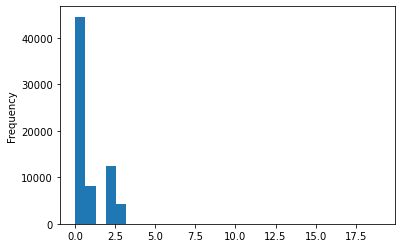

In [65]:
probs = airbnb_2022.isnull().sum(axis=1)
probs.plot.hist(bins=30)

In [66]:
airbnb_2022.drop(probs[probs > 2].index, inplace=True)

In [67]:
print(f"Have reduced data frame to: {airbnb_2022.shape[0]} rows and {airbnb_2022.shape[1]} columns")

Have reduced data frame to: 64987 rows and 27 columns


### Correct data type

In [68]:
airbnb_2016.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33709 entries, 0 to 33715
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              33709 non-null  float64
 1   name                            33709 non-null  object 
 2   host_id                         33709 non-null  float64
 3   host_name                       33709 non-null  object 
 4   neighbourhood_cleansed          33709 non-null  object 
 5   latitude                        33709 non-null  object 
 6   longitude                       33709 non-null  object 
 7   room_type                       33709 non-null  object 
 8   price                           33709 non-null  object 
 9   minimum_nights                  33709 non-null  float64
 10  availability_365                33709 non-null  float64
 11  number_of_reviews               33709 non-null  float64
 12  calculated_host_listings_count  

In [69]:
cats = ['neighbourhood_cleansed','room_type']
for c in cats:
    print(f"Converting {c}")
    airbnb_2016[c] = airbnb_2016[c].astype('category')

Converting neighbourhood_cleansed
Converting room_type


In [70]:
money = ['price']
for m in money:
    print(f"Converting {m}")
    airbnb_2016[m] = airbnb_2016[m].str.replace('$','', regex=False).str.replace(',','', regex=False).astype('float')

Converting price


In [71]:
ints  = ['id','host_id','minimum_nights','availability_365', 'number_of_reviews', 'calculated_host_listings_count']
for i in ints:
    print(f"Converting {i}")
    try:
        airbnb_2016[i] = airbnb_2016[i].astype('float').astype('int')
    except ValueError as e:
        print("  - !!!Converting to unsigned 16-bit integer!!!")
        airbnb_2016[i] = airbnb_2016[i].astype('float').astype(pd.UInt16Dtype())

Converting id
Converting host_id
Converting minimum_nights
Converting availability_365
Converting number_of_reviews
Converting calculated_host_listings_count


In [72]:
airbnb_2016.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33709 entries, 0 to 33715
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   id                              33709 non-null  int64   
 1   name                            33709 non-null  object  
 2   host_id                         33709 non-null  int64   
 3   host_name                       33709 non-null  object  
 4   neighbourhood_cleansed          33709 non-null  category
 5   latitude                        33709 non-null  object  
 6   longitude                       33709 non-null  object  
 7   room_type                       33709 non-null  category
 8   price                           33709 non-null  float64 
 9   minimum_nights                  33709 non-null  int64   
 10  availability_365                33709 non-null  int64   
 11  number_of_reviews               33709 non-null  int64   
 12  calculated_host_li

In [73]:
airbnb_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85236 entries, 0 to 85235
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   id                              85236 non-null  object
 1   name                            85236 non-null  object
 2   host_id                         85236 non-null  object
 3   host_name                       85236 non-null  object
 4   neighbourhood                   85236 non-null  object
 5   latitude                        85236 non-null  object
 6   longitude                       85236 non-null  object
 7   room_type                       85236 non-null  object
 8   price                           85236 non-null  object
 9   minimum_nights                  85236 non-null  object
 10  number_of_reviews               85236 non-null  object
 11  last_review                     85236 non-null  object
 12  reviews_per_month               85236 non-null

In [74]:
dates = ['last_review']
for d in dates:
    print("Converting " + d)
    airbnb_2019 = airbnb_2019[airbnb_2019[d].str.match(r'\d{4}-\d{2}-\d{2}', na=True)] # Drop some non-date values
    airbnb_2019[d] = pd.to_datetime(airbnb_2019[d], infer_datetime_format=True)

Converting last_review


In [75]:
cats = ['neighbourhood','room_type']
for c in cats:
    print(f"Converting {c}")
    airbnb_2019[c] = airbnb_2019[c].astype('category')

Converting neighbourhood
Converting room_type


In [76]:
money = ['price']
for m in money:
    print(f"Converting {m}")
    airbnb_2019[m] = airbnb_2019[m].str.replace('$','', regex=False).str.replace(',','', regex=False).astype('float')

Converting price


In [77]:
ints  = ['id','host_id','minimum_nights','availability_365', 'number_of_reviews', 'reviews_per_month','calculated_host_listings_count']
for i in ints:
    print(f"Converting {i}")
    try:
        airbnb_2019[i] = airbnb_2019[i].astype('float').astype('int')
    except ValueError as e:
        print("  - !!!Converting to unsigned 16-bit integer!!!")
        airbnb_2019[i] = airbnb_2019[i].astype('float').astype(pd.UInt16Dtype())

Converting id
Converting host_id
Converting minimum_nights
Converting availability_365
Converting number_of_reviews
Converting reviews_per_month
Converting calculated_host_listings_count


In [78]:
airbnb_2019.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64938 entries, 0 to 64937
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              64938 non-null  int64         
 1   name                            64938 non-null  object        
 2   host_id                         64938 non-null  int64         
 3   host_name                       64938 non-null  object        
 4   neighbourhood                   64938 non-null  category      
 5   latitude                        64938 non-null  object        
 6   longitude                       64938 non-null  object        
 7   room_type                       64938 non-null  category      
 8   price                           64938 non-null  float64       
 9   minimum_nights                  64938 non-null  int64         
 10  number_of_reviews               64938 non-null  int64         
 11  la

In [79]:
airbnb_2022.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64987 entries, 0 to 69357
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         64987 non-null  object 
 1   listing_url                64987 non-null  object 
 2   last_scraped               64987 non-null  object 
 3   name                       64980 non-null  object 
 4   host_id                    64987 non-null  float64
 5   host_name                  64987 non-null  object 
 6   host_since                 64987 non-null  object 
 7   host_location              56959 non-null  object 
 8   host_is_superhost          64980 non-null  object 
 9   host_listings_count        64987 non-null  object 
 10  host_total_listings_count  64987 non-null  float64
 11  neighbourhood_cleansed     64987 non-null  object 
 12  latitude                   64987 non-null  float64
 13  longitude                  64987 non-null  flo

In [80]:
bools = ['host_is_superhost','has_availability']
for b in bools:
    print(f"Converting {b}")
    airbnb_2022[b] = airbnb_2022[b].replace({'f':False, 't':True}).astype('bool')

Converting host_is_superhost
Converting has_availability


In [81]:
dates = ['last_scraped','host_since','calendar_last_scraped','first_review','last_review']
for d in dates:
    print("Converting " + d)
    airbnb_2022 = airbnb_2022[airbnb_2022[d].str.match(r'\d{4}-\d{2}-\d{2}', na=True)] # Drop some non-date values
    airbnb_2022[d] = pd.to_datetime(airbnb_2022[d], infer_datetime_format=True)

Converting last_scraped
Converting host_since
Converting calendar_last_scraped
Converting first_review
Converting last_review


In [82]:
cats = ['neighbourhood_cleansed','room_type']
for c in cats:
    print(f"Converting {c}")
    airbnb_2022[c] = airbnb_2022[c].astype('category')

Converting neighbourhood_cleansed
Converting room_type


In [83]:
money = ['price']
for m in money:
    print(f"Converting {m}")
    airbnb_2022[m] = airbnb_2022[m].str.replace('$','', regex=False).str.replace(',','', regex=False).astype('float')

Converting price


In [84]:
ints  = ['id','host_id','host_listings_count','host_total_listings_count','accommodates', 'minimum_nights',
         'availability_365', 'number_of_reviews']
for i in ints:
    print(f"Converting {i}")
    try:
        airbnb_2022[i] = airbnb_2022[i].astype('float').astype('int')
    except ValueError as e:
        print("  - !!!Converting to unsigned 16-bit integer!!!")
        airbnb_2022[i] = airbnb_2022[i].astype('float').astype(pd.UInt16Dtype())

Converting id
Converting host_id
Converting host_listings_count
Converting host_total_listings_count
Converting accommodates
Converting minimum_nights
Converting availability_365
Converting number_of_reviews


In [85]:
airbnb_2022.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64986 entries, 0 to 69357
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   id                         64986 non-null  int64         
 1   listing_url                64986 non-null  object        
 2   last_scraped               64986 non-null  datetime64[ns]
 3   name                       64979 non-null  object        
 4   host_id                    64986 non-null  int64         
 5   host_name                  64986 non-null  object        
 6   host_since                 64986 non-null  datetime64[ns]
 7   host_location              56958 non-null  object        
 8   host_is_superhost          64986 non-null  bool          
 9   host_listings_count        64986 non-null  int64         
 10  host_total_listings_count  64986 non-null  int64         
 11  neighbourhood_cleansed     64986 non-null  category      
 12  lati

### Save cleaned listing files locally 

In [86]:
path = os.path.join('data','clean')

if not os.path.exists(path):
    print(f"Creating {path} under {os.getcwd()}")
    os.makedirs(path)
    
airbnb_2016.to_csv(os.path.join(path,fn16), index=False)
airbnb_2019.to_csv(os.path.join(path,fn19), index=False)
airbnb_2022.to_csv(os.path.join(path,fn22), index=False)

print("Done.")

Done.


In [87]:
airbnb_2016.reset_index().to_feather(os.path.join(path,fn16.replace('.csv.gz','.feather')))
airbnb_2019.reset_index().to_feather(os.path.join(path,fn19.replace('.csv.gz','.feather')))
airbnb_2022.reset_index().to_feather(os.path.join(path,fn22.replace('.csv.gz','.feather')))

In [88]:
airbnb_2016_feather = pd.read_feather(os.path.join(path,fn16.replace('.csv.gz','.feather')))
print(f"2016 Data frame is {airbnb_2016_feather.shape[0]:,} x {airbnb_2016_feather.shape[1]}")
airbnb_2019_feather = pd.read_feather(os.path.join(path,fn19.replace('.csv.gz','.feather')))
print(f"2019 Data frame is {airbnb_2019_feather.shape[0]:,} x {airbnb_2019_feather.shape[1]}")
airbnb_2022_feather = pd.read_feather(os.path.join(path,fn22.replace('.csv.gz','.feather')))
print(f"2022 Data frame is {airbnb_2022_feather.shape[0]:,} x {airbnb_2022_feather.shape[1]}")


2016 Data frame is 33,709 x 14
2019 Data frame is 64,938 x 16
2022 Data frame is 64,986 x 28


### Geodataframe

lat/long to geoseries

In [89]:
gdf2016 = gpd.GeoDataFrame(airbnb_2016_feather, 
      geometry=gpd.points_from_xy(airbnb_2016_feather.longitude, airbnb_2016_feather.latitude, crs='epsg:4326'))
gdf2019 = gpd.GeoDataFrame(airbnb_2019_feather, 
      geometry=gpd.points_from_xy(airbnb_2019_feather.longitude, airbnb_2019_feather.latitude, crs='epsg:4326'))
gdf2022 = gpd.GeoDataFrame(airbnb_2022_feather, 
      geometry=gpd.points_from_xy(airbnb_2022_feather.longitude, airbnb_2022_feather.latitude, crs='epsg:4326'))

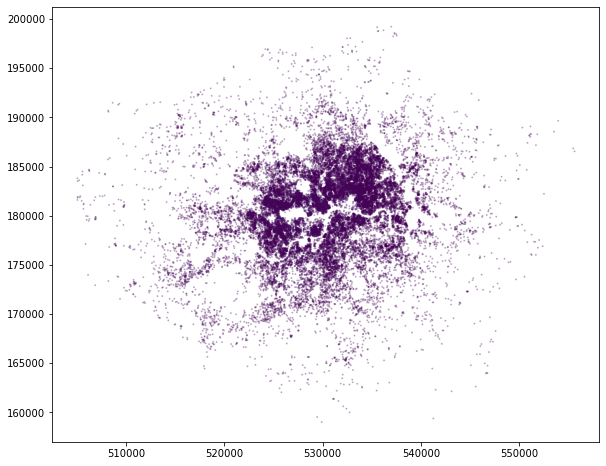

In [90]:
gdf2016.to_crs('epsg:27700').plot(column='price', cmap='viridis', alpha=0.25, markersize=1, figsize=(12,8));

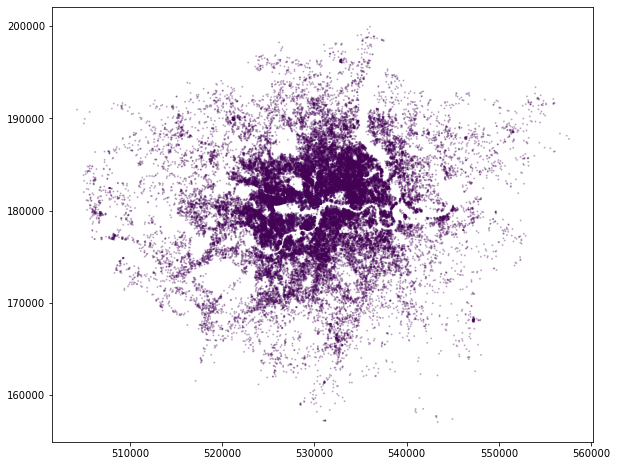

In [91]:
gdf2019.to_crs('epsg:27700').plot(column='price', cmap='viridis', alpha=0.25, markersize=1, figsize=(12,8));

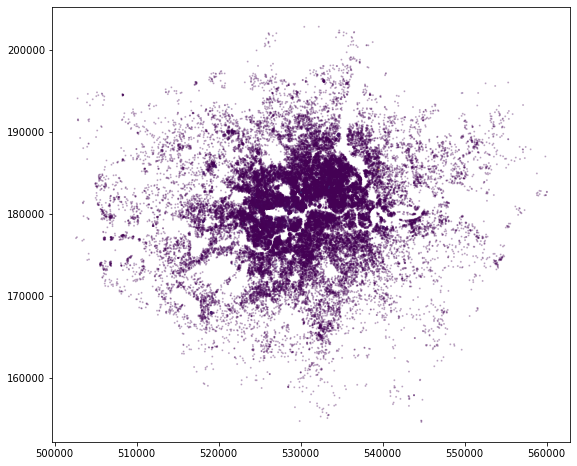

In [92]:
gdf2022.to_crs('epsg:27700').plot(column='price', cmap='viridis', alpha=0.25, markersize=1, figsize=(12,8));

In [93]:
print(f"Using '{fn16.replace('.csv.gz','.feather')}' as basis for saving data...")
gdf2016.to_feather(os.path.join('data','geo',fn16.replace('.feather','.geofeather')))
print(f"Using '{fn19.replace('.csv.gz','.feather')}' as basis for saving data...")
gdf2019.to_feather(os.path.join('data','geo',fn19.replace('.feather','.geofeather')))
print(f"Using '{fn22.replace('.csv.gz','.feather')}' as basis for saving data...")
gdf2022.to_feather(os.path.join('data','geo',fn22.replace('.feather','.geofeather')))

Using 'London-2016-02-02-listings.feather' as basis for saving data...
Using 'London-2019-11-listings.feather' as basis for saving data...
Using '2022-09-10-listings.feather' as basis for saving data...


# Descriptive summary 

In [422]:
listings16 = gpd.read_feather(os.path.join('data','geo',fn16.replace('.feather','.geofeather'))).to_crs(epsg=27700).drop(columns=['index']).set_index('id')
print(f"2016 Data frame is {listings16.shape[0]:,} x {listings16.shape[1]}")
listings19 = gpd.read_feather(os.path.join('data','geo',fn19.replace('.feather','.geofeather'))).to_crs(epsg=27700).drop(columns=['index']).set_index('id')
print(f"2019 Data frame is {listings19.shape[0]:,} x {listings19.shape[1]}")
listings22 = gpd.read_feather(os.path.join('data','geo',fn22.replace('.feather','.geofeather'))).to_crs(epsg=27700).drop(columns=['index']).set_index('id')
print(f"2022 Data frame is {listings22.shape[0]:,} x {listings22.shape[1]}")

2016 Data frame is 33,709 x 13
2019 Data frame is 64,938 x 15
2022 Data frame is 64,986 x 27


## select room type 

In [128]:
listings16.groupby('room_type')['name'].count()

room_type
Entire home/apt    17624
Private room       15602
Shared room          483
Name: name, dtype: int64

In [129]:
listings19.groupby('room_type')['name'].count()

room_type
Entire home/apt    36842
Hotel room           869
Private room       26823
Shared room          404
Name: name, dtype: int64

In [130]:
listings22.groupby('room_type')['name'].count()

room_type
Entire home/apt    38684
Hotel room           232
Private room       25722
Shared room          341
Name: name, dtype: int64

Data of three years share some common trends. High ratio of entire home / apartment followed by private room listings. This is under expectation as the intention of Airbnb is to rent out the rooms/homes that are not in use by the owners.  

Following code will extract entire home/apt listings for comparison since different types of listings may obtain varying characteristics like prices and number of guests accomodated. 

When analysing tourisification and Airbnb listings, other accomodation options for tourists should be considered, such as hotels that are not listed on Airbnb. This is included in Accomodation - hotel section. 

In [317]:
listings16_entire = listings16[listings16.room_type=='Entire home/apt']
listings19_entire = listings19[listings19.room_type=='Entire home/apt']
listings22_entire = listings22[listings22.room_type=='Entire home/apt']

## filter last review year

In [318]:
listings19_entire.last_review.head(10)

id
25796711   2019-11-06
29060134   2019-11-06
30374086   2019-11-06
37303306   2019-11-06
521359     2019-11-05
2856896    2019-11-05
5975492    2019-11-05
7141356    2019-11-05
7245085    2019-11-05
8388254    2019-11-05
Name: last_review, dtype: datetime64[ns]

In [319]:
listings22_entire.last_review.head(10)

id
15400    2020-03-16
284532   2022-01-04
17402    2022-09-06
107051   2022-09-02
284603   2022-07-04
24328    2022-07-19
286675   2022-08-22
117203   2022-06-08
288828          NaT
290233          NaT
Name: last_review, dtype: datetime64[ns]

select the recently reviewed listings in 2019 / 2022

In [323]:
listings19_entire = listings19_entire[listings19_entire['last_review'].dt.strftime('%Y') == '2019']
listings22_entire = listings22_entire[listings22_entire['last_review'].dt.strftime('%Y') == '2022']

In [324]:
listings19_entire.last_review.count()

27919

In [325]:
listings22_entire.last_review.count()

18944

This reduces the number of listings in 2019 to 27919 from around 36842 and in 2022 to 28702 from 38684. Hence, around a quarter of the listings are not active recently. 

Data in 2016 does not contain last review data information so no reduction is made. 

## drop no availability listings

Data has no availability indicates they tend to be inactive / blocked by the hosts for the coming year, yet they were active in the past year owing to the close last review date. Those listings are not included in the target for this analysis so they will be dropped. 

In [326]:
listings16_entire = listings16_entire[listings16_entire['availability_365'] != 0]
listings19_entire = listings19_entire[listings19_entire['availability_365'] != 0]
listings22_entire = listings22_entire[listings22_entire['availability_365'] != 0]

In [327]:
print(listings16_entire.name.count())
print(listings19_entire.name.count())
print(listings22_entire.name.count())

15018
22592
16418


This reduces the number of listings in 2016 to 15016 from 17624, listings in 2019 to 24927 from 27919 and listings in 2022 to 22782 from 28702. 

## Outputs

### room type change

In [426]:
listings16['room_type_count'] = listings16.groupby('room_type')['name'].transform(len)
listings19['room_type_count'] = listings19.groupby('room_type')['name'].transform(len)
listings22['room_type_count'] = listings22.groupby('room_type')['name'].transform(len)

listings16_room = listings16.drop_duplicates(subset=['room_type', 'room_type_count'],keep='last')[['room_type', 'room_type_count']].set_index('room_type')
listings19_room = listings19.drop_duplicates(subset=['room_type', 'room_type_count'],keep='last')[['room_type', 'room_type_count']].set_index('room_type')
listings22_room = listings22.drop_duplicates(subset=['room_type', 'room_type_count'],keep='last')[['room_type', 'room_type_count']].set_index('room_type')

room_type = pd.merge(listings16_room, listings19_room, left_index=True, right_index=True, how='right').fillna(0)
room_type = pd.merge(room_type, listings22_room, left_index=True, right_index=True, how='right')

room_type.columns = ['room_2016', 'room_2019', 'room_2022']  


room_2016  room_2019  room_2022
room_type                                       
Hotel room            0.00        869        232
Shared room         483.00        404        341
Private room     15,602.00      26823      25726
Entire home/apt  17,624.00      36842      38687

In [428]:
ints  = ['room_2016']
for i in ints:
    print(f"Converting {i}")
    try:
        room_type[i] = room_type[i].astype('float').astype('int')
    except ValueError as e:
        print("  - !!!Converting to unsigned 16-bit integer!!!")
        room_type[i] = room_type[i].astype('float').astype(pd.UInt16Dtype())

Converting room_2016


In [429]:
room_type

room_2016  room_2019  room_2022
room_type                                       
Hotel room               0        869        232
Shared room            483        404        341
Private room         15602      26823      25726
Entire home/apt      17624      36842      38687

KeyError: 'Hotel room'

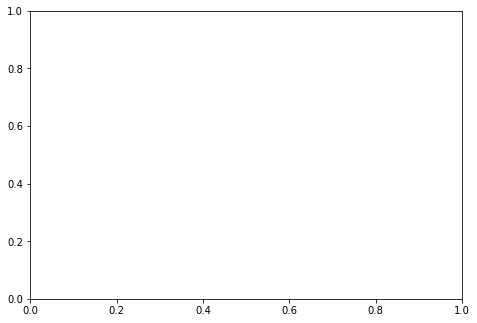

In [430]:
X = np.arange(5)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, room_type['Hotel room'], color = 'b', width = 0.25)
ax.bar(X + 0.25, room_type['Shared room'], color = 'g', width = 0.25)
ax.bar(X + 0.50, room_type['Private room'], color = 'r', width = 0.25)
ax.bar(X + 0.75, room_type['Entire home/apt'], color = 'b', width = 0.25)

### listing prices change (entire home/apt)

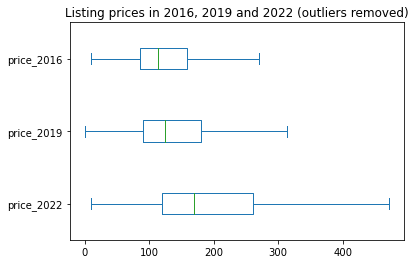

In [411]:
# put prices in 3 years in one dataframe
prices = pd.concat([listings16_entire['price'], listings19_entire['price'], listings22_entire['price']], axis=1)

# set column names (will be displayed as plot labels)
prices.columns = ['price_2016', 'price_2019', 'price_2022']  

ax = prices[['price_2022', 'price_2019', 'price_2016']].plot(kind='box',  
                                                             vert=False, 
                                                             title='Listing prices in 2016, 2019 and 2022 (outliers removed)',
                                                             showfliers=False)

# Display the plot
plt.show()


The output shows an increase in listing prices since 2016. High prices have greater increase than low prices. Outliers are removed to ensure the box plots are visible. Outliers are mostly extremely high values. 

In [ ]:
### 

# Join listing to LSOA boundary data

Select columns in LSOA atlas data used for analysis. 

In [106]:
lsoas.columns.to_list()

['geo_code',
 'geometry',
 'Names',
 '2011 Census Population;Age Structure;All Ages',
 'Population Density;Area (Hectares);',
 'Population Density;Persons per hectare;2012',
 'Population Density;Persons per hectare;2013',
 'Households;All households;2011',
 'Household Composition;Couple household with dependent children;2011',
 'Household Composition;Couple household without dependent children;2011',
 'Household Composition;Lone parent household;2011',
 'Household Composition;One person household;2011',
 'Household Composition;Other household Types;2011',
 'Household Composition;% Couple household with dependent children;2011',
 'Household Composition;% Couple household without dependent children;2011',
 'Household Composition;% Lone parent household;2011',
 'Household Composition;% One person household;2011',
 'Household Composition;% Other multi person household;2011',
 'Ethnic Group;White;2011',
 'Ethnic Group;Mixed/multiple ethnic groups;2011',
 'Ethnic Group;Asian/Asian British;20

In [104]:
lsoas_reduced = lsoas[['geo_code','geometry','Names','2011 Census Population;Age Structure;All Ages', 'Population Density;Persons per hectare;2013',
 'Ethnic Group;White (%);2011', 'Ethnic Group;Mixed/multiple ethnic groups (%);2011', 'Ethnic Group;Asian/Asian British (%);2011',
 'Ethnic Group;Black/African/Caribbean/Black British (%);2011', 'Ethnic Group;Other ethnic group (%);2011', 'Ethnic Group;BAME (%);2011',
 'Country of Birth;% United Kingdom;2011', 'Country of Birth;% Not United Kingdom;2011',
 'House Prices;Median Price (£);2014',
 'Health;Very good or Good health (%);2011', 'Health;Fair health (%);2011', 'Health;Bad or Very Bad health (%);2011',
 'Public Transport Accessibility Levels (2014);Average Score;',
 'Household Income, 2011/12;Median Annual Household Income estimate (£)',
 'Borough', 'Subregion']]

In [328]:
lsoa_listings16_entire = gpd.sjoin(listings16_entire, lsoas_reduced)
lsoa_listings19_entire = gpd.sjoin(listings19_entire, lsoas_reduced)
lsoa_listings22_entire = gpd.sjoin(listings22_entire, lsoas_reduced)

# The Occupancy Model

Estimated booking per listing = number of review * 2

Occupancy (number of night booked) = Average length of stay * estimated booking per listing per year

The number of review is total throughout the lifetime of each listing. This is less useful for comparison as listings have different start and end dates on Airbnb. Since our analysis is based on 2022, it is more reasonable to use number of reviews in the last 30 days or last 12 months for analysis.  

It is found that the average length of stay for oversea tourists in London in 2019 is 5.47 nights. 
This group is the potential target renters for Airbnb. 
However, the data is in 2019, which could be influenced by the pandemic. It would be more accurate to obtain data from 2022. 
source: https://www.statista.com/statistics/487772/average-length-overseas-visits-by-purpose-london-uk/

However, it is also suggested that when the number of minimum nights bookable is larger than the average length of stay, the minimum nights would be used for calculation. 

Thus, occupancy could be calculated as

5.47 * (number of reviews in last 12 months) * 2

or

(minimum nights) * (number of reviews in last 12 months) * 2

In [165]:
lsoa_listings16_entire['averstay'] = np.where(lsoa_listings16_entire['minimum_nights']>5.47, 
                                              lsoa_listings16_entire['minimum_nights'], 5.47)
lsoa_listings19_entire['averstay'] = np.where(lsoa_listings19_entire['minimum_nights']>5.47, 
                                              lsoa_listings19_entire['minimum_nights'], 5.47)
lsoa_listings22_entire['averstay'] = np.where(lsoa_listings22_entire['minimum_nights']>5.47, 
                                              lsoa_listings22_entire['minimum_nights'], 5.47)

/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [166]:
lsoa_listings16_entire['occupancy'] = lsoa_listings16_entire['averstay'] * lsoa_listings16_entire['number_of_reviews'] *2
lsoa_listings19_entire['occupancy'] = lsoa_listings19_entire['averstay'] * lsoa_listings19_entire['number_of_reviews'] *2
lsoa_listings22_entire['occupancy'] = lsoa_listings22_entire['averstay'] * lsoa_listings22_entire['number_of_reviews_ltm'] *2


/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [167]:
lsoa_listings22_entire[['occupancy','averstay','minimum_nights','number_of_reviews_ltm','availability_365']].head(10)

occupancy  averstay  minimum_nights  number_of_reviews_ltm  \
id                                                                     
89870        262.56      5.47               1                  24.00   
15697845     371.96      5.47               2                  34.00   
39462449     371.96      5.47               2                  34.00   
15400          0.00      5.47               3                   0.00   
9884712        0.00      9.00               9                   0.00   
15483378      32.82      5.47               3                   3.00   
17329226     251.62      5.47               3                  23.00   
19964089     120.34      5.47               3                  11.00   
22399546      65.64      5.47               3                   6.00   
23763017      43.76      5.47               4                   4.00   

          availability_365  
id                          
89870                  343  
15697845               322  
39462449               314  
15400                   70  
9884712                283  
15483378                68  
17329226               287  
19964089               303  
22399546                10  
23763017               335

In [177]:
lsoa_listings22_entire.occupancy.describe()

count   22,782.00
mean        85.08
std        201.89
min          0.00
25%          0.00
50%         32.82
75%         98.46
max      8,160.00
Name: occupancy, dtype: float64

<AxesSubplot:ylabel='Frequency'>

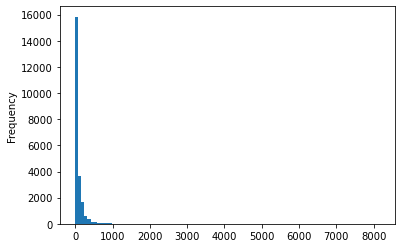

In [178]:
lsoa_listings22_entire.occupancy.plot.hist(bins=100) # histogram

In [179]:
lsoa_listings22_entire.sort_values(by = 'occupancy',ascending=False).head(20)[['name','price','minimum_nights','minimum_nights_avg_ntm','number_of_reviews_ltm','occupancy']]

name  price  \
id                                                                             
7742194                  Cosy Double studio in Zone 2 Hammersmith (8)  45.00   
24507428            Jack's place - Luxury Industrial style 1 bed flat 128.00   
4594609             £100 for entire 2 bed flat in trendy east London!  74.00   
46233904              Superior Studio for 2 people, Tower Hill London 510.00   
50299785             Designer 2 Bedroom Home w/ Garden in City Center 275.00   
576774974807499776         2 BR Flat - 3 Mins from Finsbury Park Tube  80.00   
17166154               Private cottage in Central Westminster (2 Bed) 250.00   
52710303                 Lovely entire 2 bed/2 bath in trendy Leyton!  75.00   
28825689            Beautifully renovated 2 bedroom Notting Hill flat 206.00   
48306255                  Spacious, Modern Apartment near Kings Cross 130.00   
28126889                               London/ Tower Bridge apartment 119.00   
12288022                             Great Studio Flat Central London 129.00   
36861596                               Golden Square - Classic Studio 139.00   
38622479            Studio with FREE parking in the centre of London!  80.00   
46081754                           3 Bedroom in the Heart of West End 207.00   
609252786385792896  STUNNING FLAT 8 MINUTES WALK FROM TOWER BRIDGE !! 273.00   
27252474            Nice Compact Studio Hyde Park Central London /...  91.00   
28124745            Twin-Bed Studio Flat Hyde Park Central London 13B  96.00   
21893058             A small Double Studio in Bayswater Hyde Park B33  79.00   
8946212             Modern 1 bedroom flat in central London (Vauxh... 145.00   

                    minimum_nights  minimum_nights_avg_ntm  \
id                                                           
7742194                        170                    8.60   
24507428                        90                   90.00   
4594609                        120                  120.00   
46233904                         1                    1.00   
50299785                        91                   91.00   
576774974807499776              90                   90.00   
17166154                        90                   85.00   
52710303                        90                   90.00   
28825689                        90                   88.40   
48306255                        91                   91.00   
28126889                       101                  101.00   
12288022                        90                   90.00   
36861596                         1                    5.20   
38622479                        90                   90.00   
46081754                        90                   68.30   
609252786385792896              90                   90.00   
27252474                        91                   91.00   
28124745                        91                   91.00   
21893058                        90                   90.00   
8946212                         91                   91.00   

                    number_of_reviews_ltm  occupancy  
id                                                    
7742194                             24.00   8,160.00  
24507428                            36.00   6,480.00  
4594609                             27.00   6,480.00  
46233904                           534.00   5,841.96  
50299785                            27.00   4,914.00  
576774974807499776                  27.00   4,860.00  
17166154                            26.00   4,680.00  
52710303                            26.00   4,680.00  
28825689                            24.00   4,320.00  
48306255                            22.00   4,004.00  
28126889                            19.00   3,838.00  
12288022                            21.00   3,780.00  
36861596                           332.00   3,632.08  
38622479                            19.00   3,420.00  
46081754                            19.00   3,420.00  
6092

The extremely high occupancy above 365 nights per year indicates flaws in the estimation method. 
When comparing columns minimum_nights and minimum_nights_avg_ntm, it is found  that the later could be more accurate in representing the shortest booking length, which might vary during the year controlled by the owners. 

In [180]:
lsoa_listings22_entire['averstay2'] = np.where(lsoa_listings22_entire['minimum_nights_avg_ntm']>5.47, 
                                               lsoa_listings22_entire['minimum_nights_avg_ntm'], 5.47)

In [181]:
lsoa_listings22_entire['occupancy2'] = lsoa_listings22_entire['averstay2'] * lsoa_listings22_entire['number_of_reviews_ltm'] *2

In [182]:
lsoa_listings22_entire.occupancy2.describe()

count   22,782.00
mean       138.00
std        557.57
min          0.00
25%          0.00
50%         36.00
75%        120.34
max     66,864.80
Name: occupancy2, dtype: float64

In [183]:
lsoa_listings22_entire.sort_values(by = 'occupancy2',ascending=False).head(20)[['name','price','minimum_nights_avg_ntm','number_of_reviews_ltm','occupancy2']]

name  price  \
id                                                                             
19962547                     Stunning & Modern 3-Bed Home In Victoria 591.00   
52804602            Chinatown-Soho-Piccadilly, Two Bedroom Flat for 4 499.00   
52954343                   Marylebone Mews - Beautiful 2 bedroom flat 243.00   
24507428            Jack's place - Luxury Industrial style 1 bed flat 128.00   
4594609             £100 for entire 2 bed flat in trendy east London!  74.00   
17524980            Perfect Location, Cool Cosy Bright Soho Apartment 375.00   
52508336            Soho, Piccadilly Circus & Chinatown, Two Bedrooms 499.00   
13201806             A Two Bedroom Apartment, Soho & Oxford Street :) 499.00   
17236747             Shaftesbury Avenue & Piccadilly Circus Apartment 450.00   
46233904              Superior Studio for 2 people, Tower Hill London 510.00   
3645778                           Charming Notting Hill 2BR w/ garden 160.00   
52804317                   West End - Large Studio - Sleeps 4 guests! 220.00   
50299785             Designer 2 Bedroom Home w/ Garden in City Center 275.00   
24385068            Regents Park Zone 1, Quiet Apartment Large Bal... 349.00   
576774974807499776         2 BR Flat - 3 Mins from Finsbury Park Tube  80.00   
52710303                 Lovely entire 2 bed/2 bath in trendy Leyton!  75.00   
17166154               Private cottage in Central Westminster (2 Bed) 250.00   
28825689            Beautifully renovated 2 bedroom Notting Hill flat 206.00   
40008142             #RoyalPadLondon - Earls Court Kensington&Chelsea 150.00   
14367671                  Lovely 2BD on the Corner of Portobello Road 224.00   

                    minimum_nights_avg_ntm  number_of_reviews_ltm  occupancy2  
id                                                                             
19962547                            879.80                  38.00   66,864.80  
52804602                            170.00                  36.00   12,240.00  
52954343                             90.00                  65.00   11,700.00  
24507428                             90.00                  36.00    6,480.00  
4594609                             120.00                  27.00    6,480.00  
17524980                            134.00                  24.00    6,432.00  
52508336                            116.90                  27.00    6,312.60  
13201806                             99.00                  30.00    5,940.00  
17236747                            155.00                  19.00    5,890.00  
46233904                              1.00                 534.00    5,841.96  
3645778                              90.00                  32.00    5,760.00  
52804317                            311.50                   8.00    4,984.00  
50299785                             91.00                  27.00    4,914.00  
24385068                            136.20                  18.00    4,903.20  
576774974807499776                   90.00                  27.00    4,860.00  
52710303                             90.00                  26.00    4,680.00  
17166154                             85.00                  26.00    4,420.00  
28825689                             88.40                  24.00    4,243.20  
40008142                             90.00                  23.00    4,140.00  
14367671                             90.00                  23.00    4,140.00

There are still some high values. The minimum length of stay higher than 90 nights may breach the short-term rental regulation. 

Listings that are highly occupied (occupancy>365) could be owing to high review rate or high minimum nights. Those that are frequently reviewed and obtaining high minimun nights might be less possible. Some high minimum nights might be typo from the host. Others might be that the host would like to increase the exposure of their listings but not renting them out on Airbnb platfrom, but on their own website, so the hosts set the minimum nights on purpose. Apart from those, listing with high minimum nights may breach the regulation of STR minimum night of 90 nights. Thus, those listings may bias the analysis on occupancy and they'll be removed from the dataset. However, analysis from other scopes like STR regulations on minimum nights could use the data. 

It is also possible that the long operating lifetime/number of years since first listed may result in high review rate, thus influencing the occupancy measurement. This is more likely to happen in 2016 and 2019 data that the column of number of review in last 12 months is not included. 

In [187]:
to_drop = lsoa_listings22_entire[(lsoa_listings22_entire.minimum_nights_avg_ntm > 90) | 
            (lsoa_listings22_entire.minimum_nights_avg_ntm*lsoa_listings22_entire.number_of_reviews_ltm > 365)]
to_drop.occupancy2.count()


1162

In [188]:
lsoa_listings22_entire[(lsoa_listings22_entire.occupancy2 > 365)].occupancy2.count()

1964

1162 out of 1964 are most unlikely cases. 

In [185]:
def plt_ldn(w, b):
    """
    Creates a new figure of a standard size with the 
    water (w) and boundary (b) layers set up for easy
    plotting. Right now this function assumes that you're
    looking at London, but you could parameterise it in
    other ways ot allow it to work for other areas.
    
    w: a water layer for London
    b: a borough (or other) boundary layer for London
    """
    fig, ax = plt.subplots(1, figsize=(14, 12))
    w.plot(ax=ax, color='#79aef5', zorder=2)
    b.plot(ax=ax, edgecolor='#cc2d2d', facecolor='None', zorder=3)
    ax.set_xlim([502000,563000])
    ax.set_ylim([155000,201500])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    return fig, ax

<AxesSubplot:>

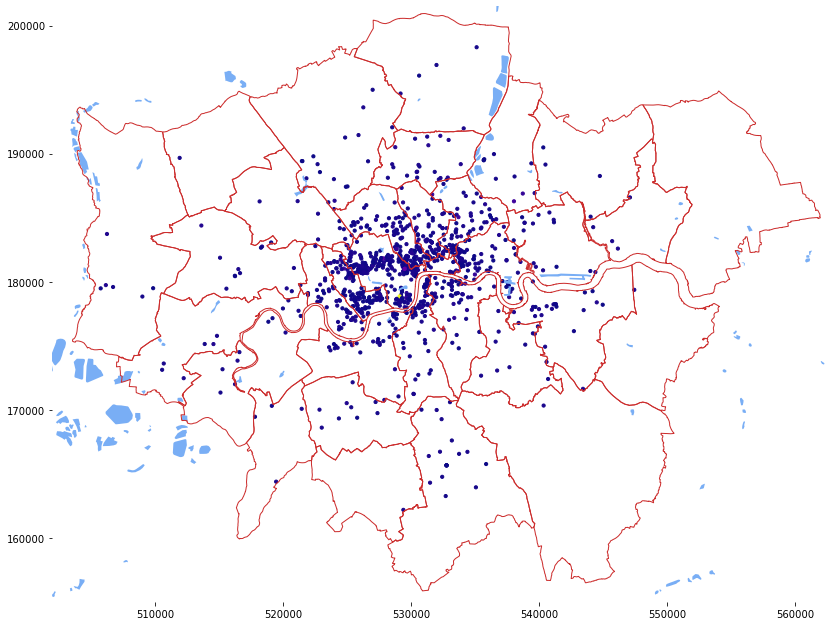

In [189]:
f,ax = plt_ldn(water, boros)
to_drop.plot(column='occupancy2', markersize=10, alpha=1, cmap='plasma', ax=ax)

In [190]:
lsoa_listings22_entire_cleaned = lsoa_listings22_entire.drop(index=to_drop.index)
print(f"Cleaned data has {lsoa_listings22_entire_cleaned.shape[0]:,} rows.")

Cleaned data has 21,620 rows.


### Note: this result above is different from the result on the Inside Airbnb website. Too many listings that are fully occupied..

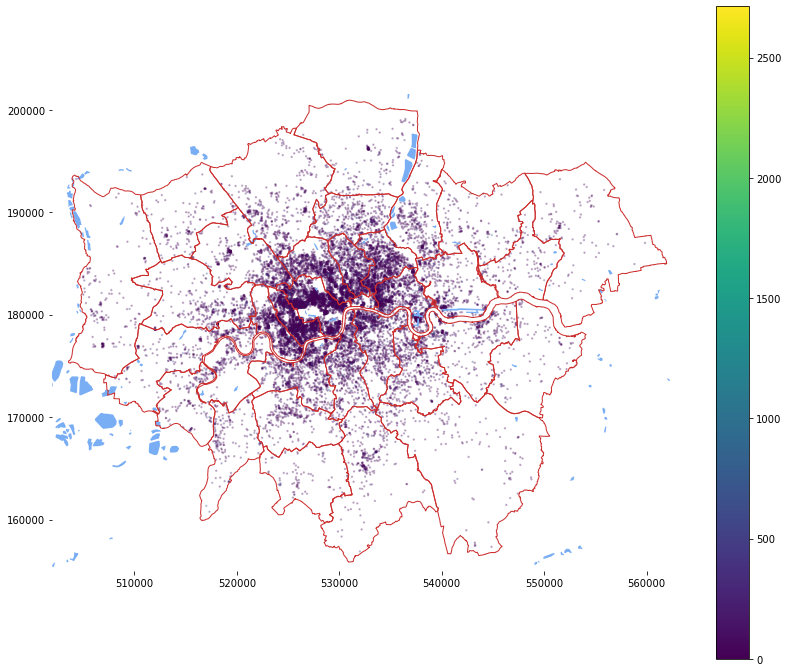

In [191]:
f,ax = plt_ldn(water, boros)
lsoa_listings22_entire_cleaned.plot(column='occupancy2', cmap='viridis', alpha=0.25, markersize=2, figsize=(12,8),legend=True,ax=ax);

## Occupancy and availability 

<AxesSubplot:ylabel='Frequency'>

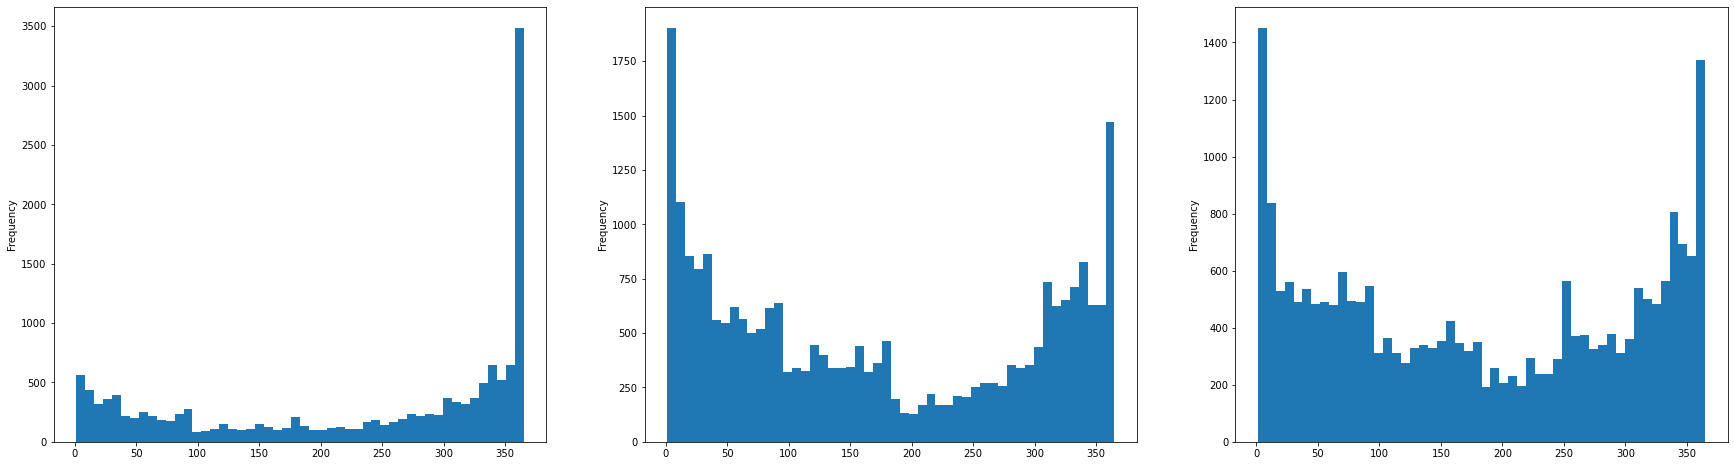

In [176]:
 # histogram
f,axes = plt.subplots(1,3,figsize=(30,8))
lsoa_listings16_entire.availability_365.plot.hist(bins=50,ax=axes[0])
lsoa_listings19_entire.availability_365.plot.hist(bins=50,ax=axes[1])
lsoa_listings22_entire.availability_365.plot.hist(bins=50,ax=axes[2]) 

Availability is polarised where the highest and lowest available listings are most frequent. 

In [260]:
lsoa_listings16_entire.describe()[['occupancy','availability_365']]

occupancy  availability_365
count  15,016.00         15,016.00
mean      150.44            233.17
std       290.60            131.26
min         0.00              1.00
25%        10.94             92.00
50%        43.76            289.00
75%       164.10            355.00
max     8,640.00            365.00

In [262]:
lsoa_listings19_entire.describe()[['occupancy','availability_365']]

occupancy  availability_365
count  24,927.00         24,927.00
mean      301.21            168.64
std     1,061.65            127.66
min        10.94              1.00
25%        43.76             46.00
50%       109.40            144.00
75%       284.44            307.00
max    50,400.00            365.00

In [192]:
lsoa_listings22_entire_cleaned.describe()[['occupancy2','availability_365']]

occupancy2  availability_365
count   21,620.00         21,620.00
mean        86.22            178.75
std        140.07            124.02
min          0.00              1.00
25%          0.00             62.00
50%         32.82            166.00
75%        109.40            304.00
max      2,713.12            365.00

since the result is highly skewed. Median would be used to determine high and low values.  The availability of the lisitng in the future 365 days as per the calender. The listing may be not available because it is booked by a guest or blocked by the host. The higher the Occupancy and the higher the availability, the higher the intensity of renting activity. But it is also possible that the availability is underestimated since the guests may pre-booked thier stay. 

In [277]:
occumid = lsoa_listings16_entire.occupancy.median()
availmid = lsoa_listings16_entire.availability_365.median()
lsoa_listings16_HH = lsoa_listings16_entire[(lsoa_listings16_entire.occupancy >= occumid) 
                                                  & (lsoa_listings16_entire.availability_365 >= availmid)]

lsoa_listings16_entire['quar'] = np.where((lsoa_listings16_entire.occupancy >= occumid) & (lsoa_listings16_entire.availability_365 >= availmid), 'HH',
                                             (np.where((lsoa_listings16_entire.occupancy >= occumid) & (lsoa_listings16_entire.availability_365 < availmid), 'HL',
                                             (np.where((lsoa_listings16_entire.occupancy < occumid) & (lsoa_listings16_entire.availability_365 < availmid), 'LL', 
                                                     'LH')))))

In [278]:
occumid = lsoa_listings19_entire.occupancy.median()
availmid = lsoa_listings19_entire.availability_365.median()
lsoa_listings19_HH = lsoa_listings19_entire[(lsoa_listings19_entire.occupancy >= occumid) 
                                                  & (lsoa_listings19_entire.availability_365 >= availmid)]

lsoa_listings19_entire['quar'] = np.where((lsoa_listings19_entire.occupancy >= occumid) & (lsoa_listings19_entire.availability_365 >= availmid), 'HH',
                                             (np.where((lsoa_listings19_entire.occupancy >= occumid) & (lsoa_listings19_entire.availability_365 < availmid), 'HL',
                                             (np.where((lsoa_listings19_entire.occupancy < occumid) & (lsoa_listings19_entire.availability_365 < availmid), 'LL', 
                                                     'LH')))))

In [279]:
occumid = lsoa_listings22_entire_cleaned.occupancy2.median()
availmid = lsoa_listings22_entire_cleaned.availability_365.median()
lsoa_listings22_HH = lsoa_listings22_entire_cleaned[(lsoa_listings22_entire_cleaned.occupancy2 >= occumid) 
                                                  & (lsoa_listings22_entire_cleaned.availability_365 >= availmid)]

lsoa_listings22_entire_cleaned['quar'] = np.where((lsoa_listings22_entire_cleaned.occupancy2 >= occumid) & (lsoa_listings22_entire_cleaned.availability_365 >= availmid), 'HH',
                                             (np.where((lsoa_listings22_entire_cleaned.occupancy2 >= occumid) & (lsoa_listings22_entire_cleaned.availability_365 < availmid), 'HL',
                                             (np.where((lsoa_listings22_entire_cleaned.occupancy2 < occumid) & (lsoa_listings22_entire_cleaned.availability_365 < availmid), 'LL', 
                                                     'LH')))))

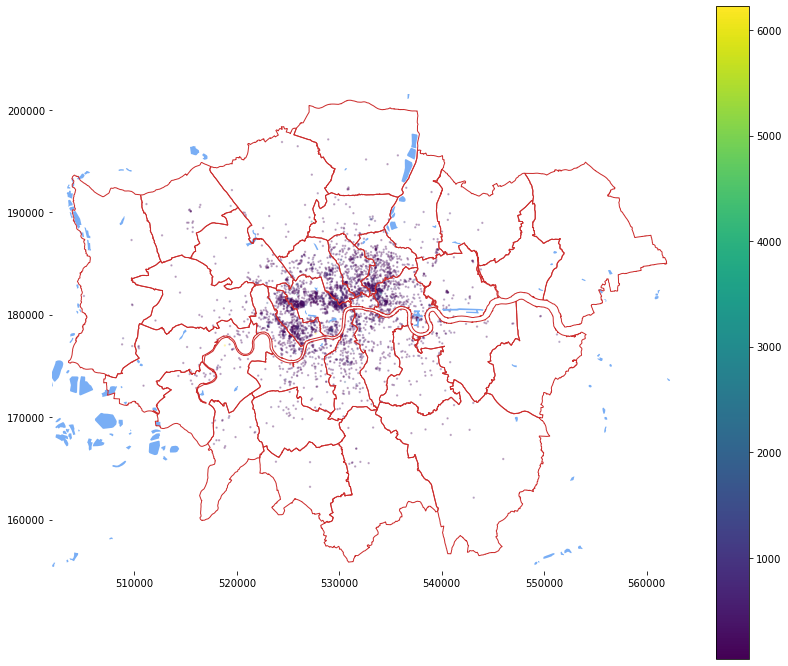

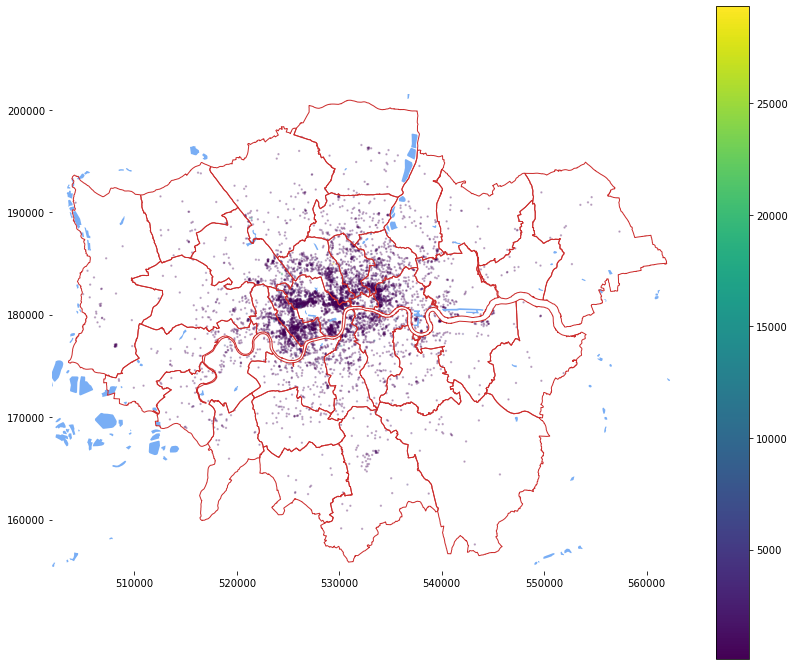

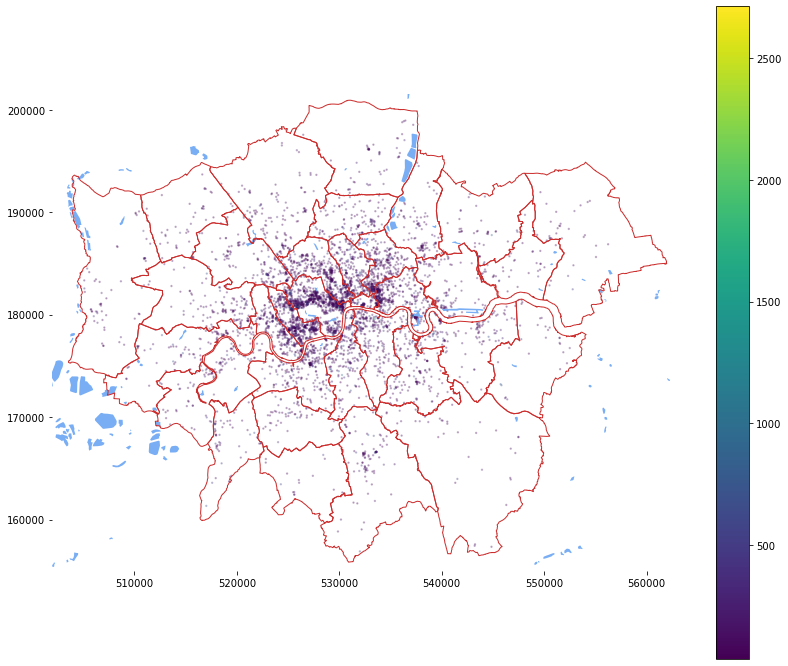

In [280]:
f,ax = plt_ldn(water, boros)
lsoa_listings16_HH.plot(column='occupancy', cmap='viridis', alpha=0.25, markersize=2, figsize=(12,8),legend=True,ax=ax);
f,ax = plt_ldn(water, boros)
lsoa_listings19_HH.plot(column='occupancy', cmap='viridis', alpha=0.25, markersize=2, figsize=(12,8),legend=True,ax=ax);
f,ax = plt_ldn(water, boros)
lsoa_listings22_HH.plot(column='occupancy2', cmap='viridis', alpha=0.25, markersize=2, figsize=(12,8),legend=True,ax=ax);

In [282]:
lsoa_listings16_entire.head(10)[['quar','occupancy','availability_365']] #to check

quar  occupancy  availability_365
id                                       
8950456   LL      21.88                52
375799    HH     630.00               290
5796403   HH      98.46               351
9731112   LL       0.00                 9
6781198   HH      65.64               364
4755686   LH       0.00               356
5322833   HH     153.16               347
9802840   LL       0.00               146
6735259   LL      32.82               226
8084116   LH      21.88               332

In [197]:
lsoa_listings22_entire_cleaned.head(10)[['quar','occupancy2','availability_365']] #to check

quar  occupancy2  availability_365
id                                         
89870      HH      262.56               343
15697845   HH      371.96               322
39462449   HH      371.96               314
15400      LL        0.00                70
9884712    LH        0.00               283
15483378   HL       32.82                68
19964089   HH      120.34               303
22399546   HL       65.64                10
23763017   HH       43.76               335
28269728   HL       42.00                18

In [283]:
cats2 = ['quar']
for c in cats2:
    print(f"Converting {c}")
    lsoa_listings16_entire[c] = lsoa_listings16_entire[c].astype('category')
    lsoa_listings19_entire[c] = lsoa_listings19_entire[c].astype('category')
    lsoa_listings22_entire_cleaned[c] = lsoa_listings22_entire_cleaned[c].astype('category')

Converting quar


group by lsoas

In [289]:
pivot16 = lsoa_listings16_entire.groupby(['geo_code','quar']).name.agg(Count='count').reset_index().pivot(index='geo_code', columns=['quar'], values=['Count'])
pivot16.columns = ['HH','HL','LH','LL']
quar16 = pd.merge(lsoas_reduced.set_index('geo_code'), pivot16, left_index=True, right_index=True, how='left').fillna(0)
quar16.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 4835 entries, E01003513 to E01004020
Data columns (total 24 columns):
 #   Column                                                                 Non-Null Count  Dtype   
---  ------                                                                 --------------  -----   
 0   geometry                                                               4835 non-null   geometry
 1   Names                                                                  4835 non-null   object  
 2   2011 Census Population;Age Structure;All Ages                          4835 non-null   float64 
 3   Population Density;Persons per hectare;2013                            4835 non-null   float64 
 4   Ethnic Group;White (%);2011                                            4835 non-null   float64 
 5   Ethnic Group;Mixed/multiple ethnic groups (%);2011                     4835 non-null   float64 
 6   Ethnic Group;Asian/Asian British (%);2011                       

In [297]:
pivot19 = lsoa_listings19_entire.groupby(['geo_code','quar']).name.agg(Count='count').reset_index().pivot(index='geo_code', columns=['quar'], values=['Count'])
pivot19.columns = ['HH','HL','LH','LL']
quar19 = pd.merge(lsoas_reduced.set_index('geo_code'), pivot19, left_index=True, right_index=True, how='left').fillna(0)
quar19.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 4835 entries, E01003513 to E01004020
Data columns (total 24 columns):
 #   Column                                                                 Non-Null Count  Dtype   
---  ------                                                                 --------------  -----   
 0   geometry                                                               4835 non-null   geometry
 1   Names                                                                  4835 non-null   object  
 2   2011 Census Population;Age Structure;All Ages                          4835 non-null   float64 
 3   Population Density;Persons per hectare;2013                            4835 non-null   float64 
 4   Ethnic Group;White (%);2011                                            4835 non-null   float64 
 5   Ethnic Group;Mixed/multiple ethnic groups (%);2011                     4835 non-null   float64 
 6   Ethnic Group;Asian/Asian British (%);2011                       

In [285]:
pivot22 = lsoa_listings22_entire_cleaned.groupby(['geo_code','quar']).listing_url.agg(Count='count')
                                        .reset_index().pivot(index='geo_code', columns=['quar'], values=['Count'])
pivot22.columns = ['HH','HL','LH','LL']
quar22 = pd.merge(lsoas_reduced.set_index('geo_code'), pivot22, left_index=True, right_index=True, how='left').fillna(0)
quar22.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 4835 entries, E01003513 to E01004020
Data columns (total 24 columns):
 #   Column                                                                 Non-Null Count  Dtype   
---  ------                                                                 --------------  -----   
 0   geometry                                                               4835 non-null   geometry
 1   Names                                                                  4835 non-null   object  
 2   2011 Census Population;Age Structure;All Ages                          4835 non-null   float64 
 3   Population Density;Persons per hectare;2013                            4835 non-null   float64 
 4   Ethnic Group;White (%);2011                                            4835 non-null   float64 
 5   Ethnic Group;Mixed/multiple ethnic groups (%);2011                     4835 non-null   float64 
 6   Ethnic Group;Asian/Asian British (%);2011                       

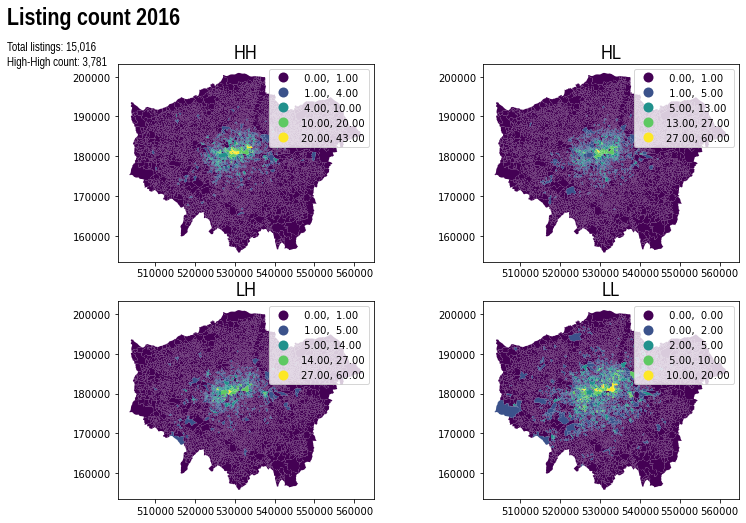

In [301]:
f,axes = plt.subplots(2,2,figsize=(12,8))

quar16.plot(column='HH', ax=axes[0,0], scheme='fisherjenks', legend=True, cmap='viridis')
axes[0,0].set_title('HH', size=20, **afont)

quar16.plot(column='HL', ax=axes[0,1], scheme='fisherjenks',legend=True, cmap='viridis')
axes[0,1].set_title('HL', size=20, **afont)

quar16.plot(column='LH', ax=axes[1,0], scheme='fisherjenks',legend=True, cmap='viridis')
axes[1,0].set_title('LH', size=20, **afont)

quar16.plot(column='LL', ax=axes[1,1], scheme='fisherjenks',legend=True, cmap='viridis')
axes[1,1].set_title('LL', size=20, **afont)

f.suptitle('Listing count 2016', x=0.025, ha='left', size=24, **tfont)

plt.figtext(x=0.025, y=0.92, linespacing=1.4, va='top', size=12, 
            s=f"Total listings: {lsoa_listings16_entire.name.count():,.0f}\nHigh-High count: {quar16['HH'].sum():,.0f}", **bfont);

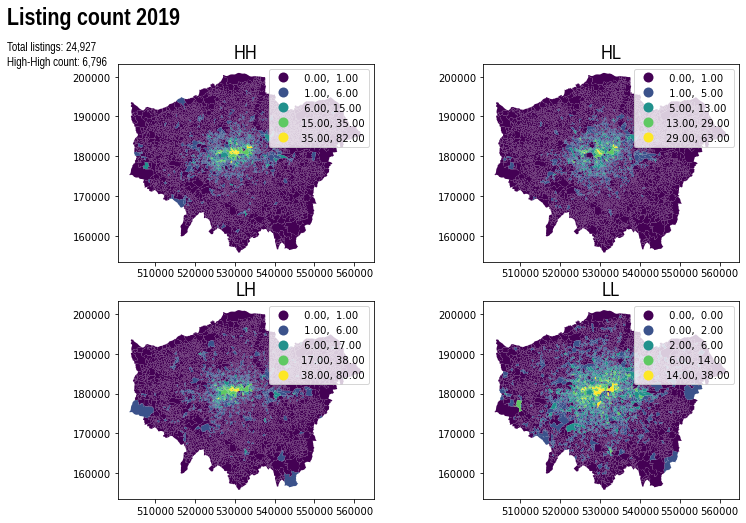

In [302]:
f,axes = plt.subplots(2,2,figsize=(12,8))

quar19.plot(column='HH', ax=axes[0,0], scheme='fisherjenks', legend=True, cmap='viridis')
axes[0,0].set_title('HH', size=20, **afont)

quar19.plot(column='HL', ax=axes[0,1], scheme='fisherjenks',legend=True, cmap='viridis')
axes[0,1].set_title('HL', size=20, **afont)

quar19.plot(column='LH', ax=axes[1,0], scheme='fisherjenks',legend=True, cmap='viridis')
axes[1,0].set_title('LH', size=20, **afont)

quar19.plot(column='LL', ax=axes[1,1], scheme='fisherjenks',legend=True, cmap='viridis')
axes[1,1].set_title('LL', size=20, **afont)

f.suptitle('Listing count 2019', x=0.025, ha='left', size=24, **tfont)

plt.figtext(x=0.025, y=0.92, linespacing=1.4, va='top', size=12, 
            s=f"Total listings: {lsoa_listings19_entire.name.count():,.0f}\nHigh-High count: {quar19['HH'].sum():,.0f}", **bfont);

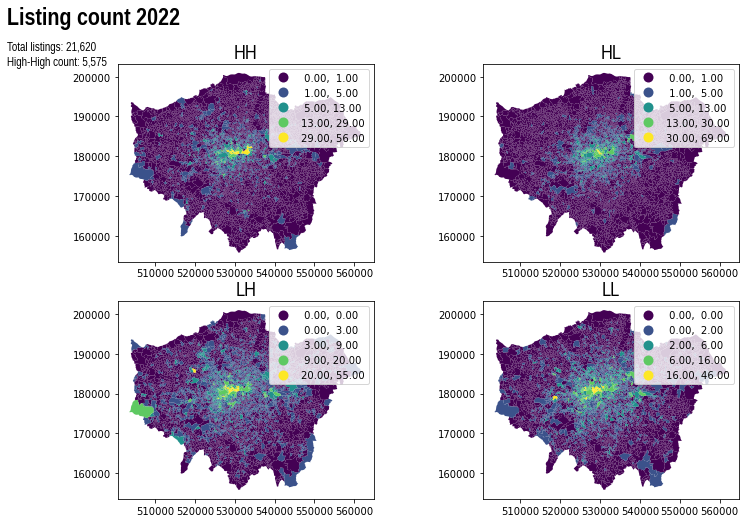

In [303]:
f,axes = plt.subplots(2,2,figsize=(12,8))

quar22.plot(column='HH', ax=axes[0,0], scheme='fisherjenks', legend=True, cmap='viridis')
axes[0,0].set_title('HH', size=20, **afont)

quar22.plot(column='HL', ax=axes[0,1], scheme='fisherjenks',legend=True, cmap='viridis')
axes[0,1].set_title('HL', size=20, **afont)

quar22.plot(column='LH', ax=axes[1,0], scheme='fisherjenks',legend=True, cmap='viridis')
axes[1,0].set_title('LH', size=20, **afont)

quar22.plot(column='LL', ax=axes[1,1], scheme='fisherjenks',legend=True, cmap='viridis')
axes[1,1].set_title('LL', size=20, **afont)

f.suptitle('Listing count 2022', x=0.025, ha='left', size=24, **tfont)

plt.figtext(x=0.025, y=0.92, linespacing=1.4, va='top', size=12, 
            s=f"Total listings: {lsoa_listings22_entire_cleaned.listing_url.count():,.0f}\nHigh-High count: {quar22['HH'].sum():,.0f}", **bfont);

Text(0.025, 0.98, 'Population density per LSOAs in 2013')

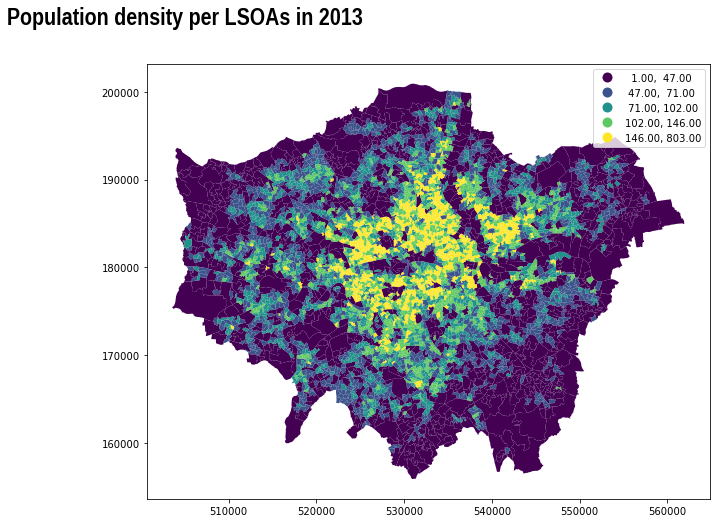

In [224]:
f,ax = plt.subplots(1,1,figsize=(12,8))

quar22.plot(column='Population Density;Persons per hectare;2013', 
          ax=ax, 
          legend=True, 
          cmap='viridis',
          scheme='quantiles')
f.suptitle('Population density per LSOAs in 2013', x=0.025, ha='left', size=24, **tfont)


From the outputs, the high occupancy and high availability listings are concentrated in inner London LSOAs, where the total listings are high overall. Although highly rented and highly available listings are concentrated in inner London, other types are also concentrated in inner London. The high counts of listings in central locations tend to imply high popularity as tourists destinations throughout the years. The large range of the listing counts is seen as the low counts in purple colour has high coverage, while LSOAs with the high counts are rare, concentrated around inner London, where the population density is lower. 

Percentage of each type within the LSOAs would be measured to investigate the ratio. 

In [306]:
quar_density16 = quar16.copy()
quar_density16['count'] = quar_density16.loc[:,['HH','HL','LH','LL']].sum(axis=1)
quar_density16['HHper'] = quar_density16['HH'] / quar_density16['count']
quar_density16['HLper'] = quar_density16['HL'] / quar_density16['count']
quar_density16['LHper'] = quar_density16['LH'] / quar_density16['count']
quar_density16['LLper'] = quar_density16['LL'] / quar_density16['count']
quar_density16 = quar_density16.fillna(0)

In [307]:
quar_density19 = quar19.copy()
quar_density19['count'] = quar_density19.loc[:,['HH','HL','LH','LL']].sum(axis=1)
quar_density19['HHper'] = quar_density19['HH'] / quar_density19['count']
quar_density19['HLper'] = quar_density19['HL'] / quar_density19['count']
quar_density19['LHper'] = quar_density19['LH'] / quar_density19['count']
quar_density19['LLper'] = quar_density19['LL'] / quar_density19['count']
quar_density19 = quar_density19.fillna(0)

In [305]:
quar_density22 = quar22.copy()
quar_density22['count'] = quar_density22.loc[:,['HH','HL','LH','LL']].sum(axis=1)
quar_density22['HHper'] = quar_density22['HH'] / quar_density22['count']
quar_density22['HLper'] = quar_density22['HL'] / quar_density22['count']
quar_density22['LHper'] = quar_density22['LH'] / quar_density22['count']
quar_density22['LLper'] = quar_density22['LL'] / quar_density22['count']
quar_density22 = quar_density22.fillna(0)

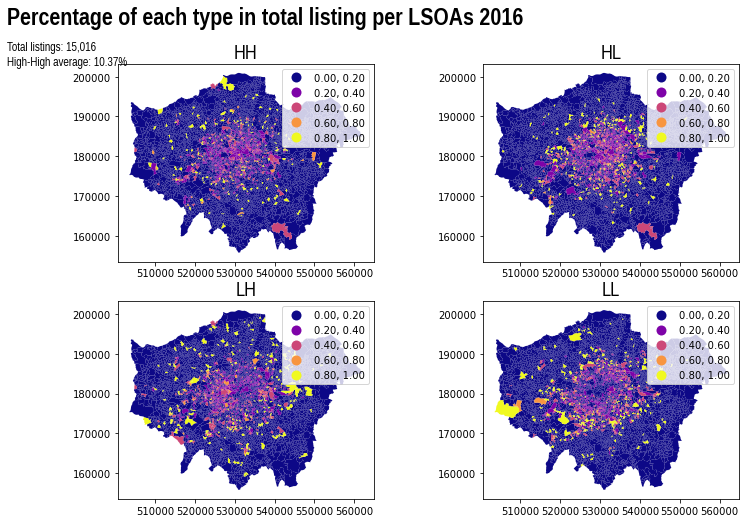

In [308]:
f,axes = plt.subplots(2,2,figsize=(12,8))

quar_density16.plot(column='HHper', ax=axes[0,0], scheme = 'equalinterval',legend=True, cmap='plasma')
axes[0,0].set_title('HH', size=20, **afont)

quar_density16.plot(column='HLper', ax=axes[0,1],scheme = 'equalinterval', legend=True, cmap='plasma')
axes[0,1].set_title('HL', size=20, **afont)

quar_density16.plot(column='LHper', ax=axes[1,0], scheme = 'equalinterval',legend=True, cmap='plasma')
axes[1,0].set_title('LH', size=20, **afont)

quar_density16.plot(column='LLper', ax=axes[1,1], scheme = 'equalinterval',legend=True, cmap='plasma')
axes[1,1].set_title('LL', size=20, **afont)

f.suptitle('Percentage of each type in total listing per LSOAs 2016', x=0.025, ha='left', size=24, **tfont)

plt.figtext(x=0.025, y=0.92, linespacing=1.4, va='top', size=12, 
            s=f"Total listings: {quar_density16['count'].sum():,.0f}\nHigh-High average: {quar_density16['HHper'].mean()*100:,.2f}%", **bfont);

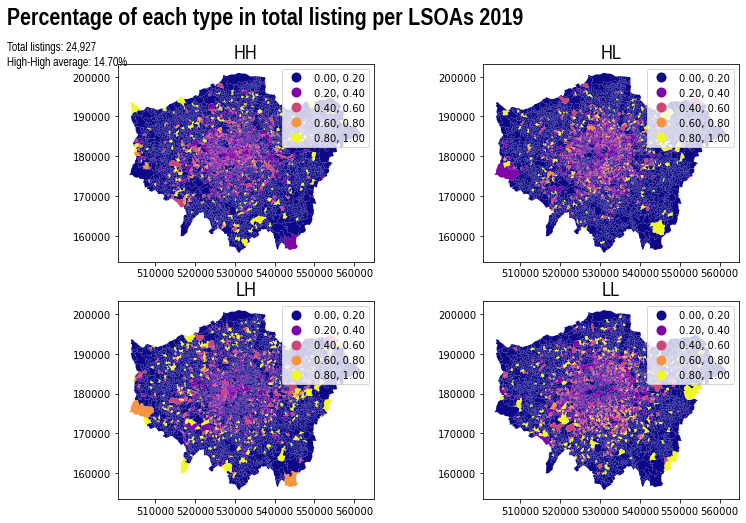

In [309]:
f,axes = plt.subplots(2,2,figsize=(12,8))

quar_density19.plot(column='HHper', ax=axes[0,0], scheme = 'equalinterval',legend=True, cmap='plasma')
axes[0,0].set_title('HH', size=20, **afont)

quar_density19.plot(column='HLper', ax=axes[0,1],scheme = 'equalinterval', legend=True, cmap='plasma')
axes[0,1].set_title('HL', size=20, **afont)

quar_density19.plot(column='LHper', ax=axes[1,0], scheme = 'equalinterval',legend=True, cmap='plasma')
axes[1,0].set_title('LH', size=20, **afont)

quar_density19.plot(column='LLper', ax=axes[1,1], scheme = 'equalinterval',legend=True, cmap='plasma')
axes[1,1].set_title('LL', size=20, **afont)

f.suptitle('Percentage of each type in total listing per LSOAs 2019', x=0.025, ha='left', size=24, **tfont)

plt.figtext(x=0.025, y=0.92, linespacing=1.4, va='top', size=12, 
            s=f"Total listings: {quar_density19['count'].sum():,.0f}\nHigh-High average: {quar_density19['HHper'].mean()*100:,.2f}%", **bfont);

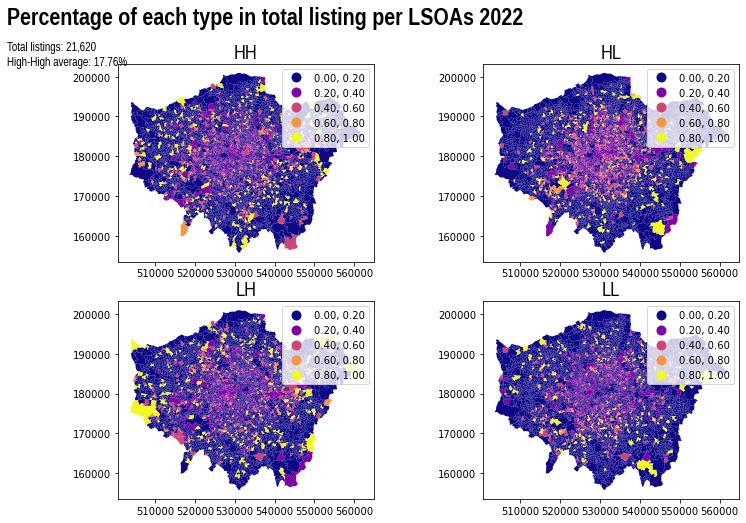

In [310]:
f,axes = plt.subplots(2,2,figsize=(12,8))

quar_density22.plot(column='HHper', ax=axes[0,0], scheme = 'equalinterval',legend=True, cmap='plasma')
axes[0,0].set_title('HH', size=20, **afont)

quar_density22.plot(column='HLper', ax=axes[0,1],scheme = 'equalinterval', legend=True, cmap='plasma')
axes[0,1].set_title('HL', size=20, **afont)

quar_density22.plot(column='LHper', ax=axes[1,0], scheme = 'equalinterval',legend=True, cmap='plasma')
axes[1,0].set_title('LH', size=20, **afont)

quar_density22.plot(column='LLper', ax=axes[1,1], scheme = 'equalinterval',legend=True, cmap='plasma')
axes[1,1].set_title('LL', size=20, **afont)

f.suptitle('Percentage of each type in total listing per LSOAs 2022', x=0.025, ha='left', size=24, **tfont)

plt.figtext(x=0.025, y=0.92, linespacing=1.4, va='top', size=12, 
            s=f"Total listings: {quar_density22['count'].sum():,.0f}\nHigh-High average: {quar_density22['HHper'].mean()*100:,.2f}%", **bfont);

This result shows that the high listing counts in inner London LSOAs have mostly equal ratio of four types of listings when comparing between 4 maps for the same year.  

When comparing between years, the LSOAs tend to have more polarised listing configuration - as the yellow colour spots increases especially in outer London. 

# Housing price

## Read in data

# Tourist attractions

## Read in data

In [406]:
# OpenStreetMap Point of Interest (POI) data source: 
# http://download.geofabrik.de/europe/great-britain/england/greater-london.html

In [336]:
OSM = gpd.read_file('data/greater-london-latest-free.shp/gis_osm_pois_a_free_1.shp')
OSM.crs

In [339]:
OSM = OSM.to_crs('epsg:27700')
OSM.crs

<Derived Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.0, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [340]:
OSM.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 45622 entries, 0 to 45621
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   osm_id    45622 non-null  object  
 1   code      45622 non-null  int64   
 2   fclass    45622 non-null  object  
 3   name      31259 non-null  object  
 4   geometry  45622 non-null  geometry
dtypes: geometry(1), int64(1), object(3)
memory usage: 1.7+ MB


In [343]:
#select tourist attraction only
tour = ['attraction', 'museum', 'art', 'picnic_site', 'viewpoint', 'zoo', 'theme_park']
OSM_tour = OSM[OSM['fclass'].isin(tour)]

In [344]:
OSM_tour.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 367 entries, 83 to 45599
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   osm_id    367 non-null    object  
 1   code      367 non-null    int64   
 2   fclass    367 non-null    object  
 3   name      332 non-null    object  
 4   geometry  367 non-null    geometry
dtypes: geometry(1), int64(1), object(3)
memory usage: 17.2+ KB


In [369]:
lsoas_reduced2 = lsoas[['geo_code','geometry','Names', 'Borough', 'Subregion']]

## Spatial join with LSOA boundaries and count the number of attractions per LSOA

In [370]:
lsoa_tour = gpd.sjoin(OSM_tour, lsoas_reduced2, how="inner", predicate='intersects')
lsoa_tour['tour_in_lsoa'] = lsoa_tour.groupby('geo_code')['name'].transform(len)
lsoa_tour.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 406 entries, 83 to 44965
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   osm_id        406 non-null    object  
 1   code          406 non-null    int64   
 2   fclass        406 non-null    object  
 3   name          370 non-null    object  
 4   geometry      406 non-null    geometry
 5   index_right   406 non-null    int64   
 6   geo_code      406 non-null    object  
 7   Names         406 non-null    object  
 8   Borough       406 non-null    object  
 9   Subregion     406 non-null    object  
 10  tour_in_lsoa  406 non-null    int64   
dtypes: geometry(1), int64(3), object(7)
memory usage: 38.1+ KB


In [376]:
lsoas_tour_id = lsoa_tour.drop_duplicates(subset=['geo_code', 'tour_in_lsoa'],keep='last')
lsoas_tour_id = lsoas_tour_id[['geo_code', 'Names','tour_in_lsoa']]

In [390]:
lsoas_tour_id.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 224 entries, 32191 to 44965
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   geo_code      224 non-null    object
 1   Names         224 non-null    object
 2   tour_in_lsoa  224 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 7.0+ KB


In [395]:
lsoas_tour_geo = pd.merge(lsoas_reduced2, lsoas_tour_id,left_on = 'geo_code', right_on = 'geo_code',how='left').fillna(0)
lsoas_tour_geo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 4835 entries, 0 to 4834
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   geo_code      4835 non-null   object  
 1   geometry      4835 non-null   geometry
 2   Names_x       4835 non-null   object  
 3   Borough       4835 non-null   object  
 4   Subregion     4835 non-null   object  
 5   Names_y       4835 non-null   object  
 6   tour_in_lsoa  4835 non-null   float64 
dtypes: float64(1), geometry(1), object(5)
memory usage: 302.2+ KB


Text(0.025, 0.98, 'Count of tourist attractions per LSOAs in 2022')

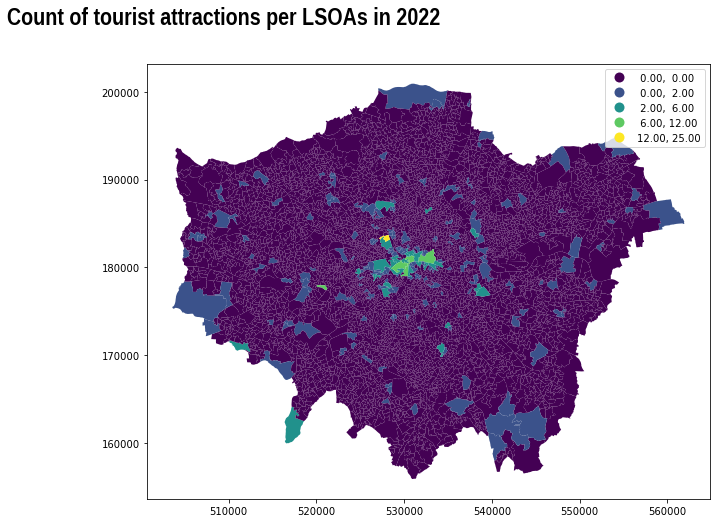

In [399]:
f,ax = plt.subplots(1,1,figsize=(12,8))

lsoas_tour_geo.plot(column='tour_in_lsoa', 
          ax=ax, 
          legend=True, 
          cmap='viridis',
          scheme='naturalbreaks')
f.suptitle('Count of tourist attractions per LSOAs in 2022', x=0.025, ha='left', size=24, **tfont)


# Accomodation - hotel

## Read in data

In [341]:
#select hotels only
OSM_hotel = OSM[OSM['fclass']=='hotel']

In [357]:
OSM_hotel.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1057 entries, 155 to 45325
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   osm_id    1057 non-null   object  
 1   code      1057 non-null   int64   
 2   fclass    1057 non-null   object  
 3   name      1051 non-null   object  
 4   geometry  1057 non-null   geometry
dtypes: geometry(1), int64(1), object(3)
memory usage: 49.5+ KB


## Spatial join with LSOA boundaries and count the number of hotels per LSOA

In [400]:
lsoa_hotel = gpd.sjoin(OSM_hotel, lsoas_reduced2, how="inner", predicate='intersects')
lsoa_hotel['hotel_in_lsoa'] = lsoa_hotel.groupby('geo_code')['name'].transform(len)
lsoa_hotel.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1169 entries, 155 to 44766
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   osm_id         1169 non-null   object  
 1   code           1169 non-null   int64   
 2   fclass         1169 non-null   object  
 3   name           1163 non-null   object  
 4   geometry       1169 non-null   geometry
 5   index_right    1169 non-null   int64   
 6   geo_code       1169 non-null   object  
 7   Names          1169 non-null   object  
 8   Borough        1169 non-null   object  
 9   Subregion      1169 non-null   object  
 10  hotel_in_lsoa  1169 non-null   int64   
dtypes: geometry(1), int64(3), object(7)
memory usage: 109.6+ KB


In [402]:
lsoas_hotel_id = lsoa_hotel.drop_duplicates(subset=['geo_code', 'hotel_in_lsoa'],keep='last')
lsoas_hotel_id = lsoas_hotel_id[['geo_code', 'Names','hotel_in_lsoa']]

In [403]:
lsoas_hotel_id.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 444 entries, 155 to 44766
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   geo_code       444 non-null    object
 1   Names          444 non-null    object
 2   hotel_in_lsoa  444 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 13.9+ KB


In [404]:
lsoas_hotel_geo = pd.merge(lsoas_reduced2, lsoas_hotel_id,left_on = 'geo_code', right_on = 'geo_code',how='left').fillna(0)
lsoas_hotel_geo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 4835 entries, 0 to 4834
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   geo_code       4835 non-null   object  
 1   geometry       4835 non-null   geometry
 2   Names_x        4835 non-null   object  
 3   Borough        4835 non-null   object  
 4   Subregion      4835 non-null   object  
 5   Names_y        4835 non-null   object  
 6   hotel_in_lsoa  4835 non-null   float64 
dtypes: float64(1), geometry(1), object(5)
memory usage: 302.2+ KB


Text(0.025, 0.98, 'Count of hotels per LSOAs in 2022')

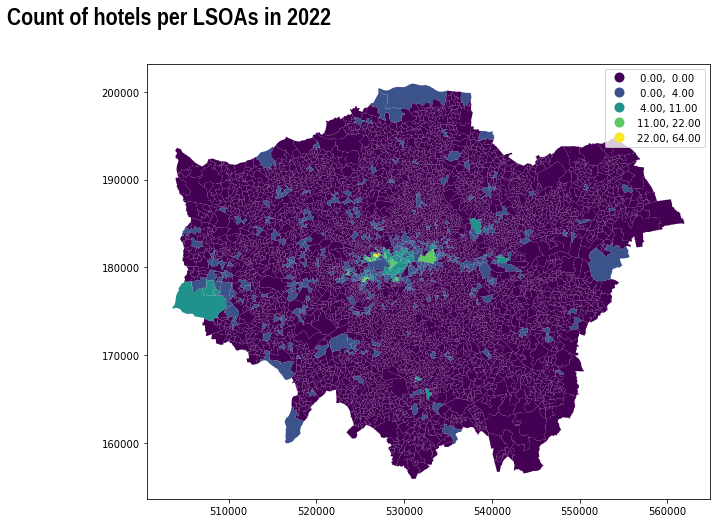

In [405]:
f,ax = plt.subplots(1,1,figsize=(12,8))

lsoas_hotel_geo.plot(column='hotel_in_lsoa', 
          ax=ax, 
          legend=True, 
          cmap='viridis',
          scheme='naturalbreaks')
f.suptitle('Count of hotels per LSOAs in 2022', x=0.025, ha='left', size=24, **tfont)


# Analysis 

## Regression